# Simulation for sensitivity analysis

# System Parameters and Experimental Setup

## Problem Dimensions
We consider a large-scale LLM inference service provider managing **I = 6** query types across **J = 6** foundation models deployed on **K = 10** heterogeneous GPU configurations. The system supports tensor parallelism with **N = 4** degrees: {1, 2, 4, 8} GPUs per model instance.

## Query Types and Workload Characteristics
The query types represent diverse real-world AI applications:
- **Text Processing**: Summarization, Code Generation, Translation
- **Reasoning Tasks**: Math Problem Solving  
- **Multimodal Generation**: Image Generation, Video Generation

Query arrival rates $\lambda_i$ follow empirical distributions from production LLM services, with text-based tasks exhibiting higher demand (80-140 queries/hour) and resource-intensive multimodal tasks showing lower but critical demand (10-60 queries/hour).

## LLM Models
We evaluate six Llama-3 family models spanning three orders of magnitude in size:
| Model | Size (GB) | Characteristics |
|-------|-----------|-----------------|
| Llama-3.2-1B | 2 | Lightweight, edge deployment |
| Llama-3.2-3B | 6 | Mobile-optimized |
| Llama-3.1-8B | 16 | General purpose |
| Llama-3.2-11B-Vision | 22 | Multimodal |
| Llama-3.2-31B | 810 | High-capacity |
| Llama-3.1-70B | 140 | Frontier model |

## GPU Infrastructure
The GPU pool consists of 10 configurations across three tiers (consumer, professional, data center), supporting multiple precision modes:

| Tier | Model | Memory (GB) | Compute (TFLOPs) | Cost ($/hr) |
|------|-------|-------------|------------------|-------------|
| Consumer | RTX 4090 (FP16/INT8/INT4) | 24 | 82.6-123.9 | 0.35 |
| Professional | A6000 (FP16/INT8/INT4) | 48 | 40.7-67.0 | 0.65 |
| Data Center | A100-40GB (FP16/INT8) | 40 | 165.2-468.0 | 1.20 |
| Premium | H100-80GB (FP16/INT8) | 80 | 989.0-1483.5 | 2.00-2.50 |

Costs reflect spot pricing from cloud GPU marketplaces (vast.ai, RunPod) with ±20% market variation.

## Performance Parameters

### Delay Model
Processing delay $d_{ij}$ (ms/token) follows transformer computational complexity $O(n^2d)$:
- **Base delays**: Task-dependent (0.3-4.0 ms/token)
- **Model multipliers**: Size-proportional (0.3× for 1B to 5× for 70B models)
- **Uncertainty**: Delay deviations $\hat{d}_{ij}$ = 10-25% of nominal values

### Error Rate Model  
Error rate $e_{ij}$ inversely correlates with model capacity:
$$e_{ij} = \frac{\text{base\_error}_i}{\text{model\_capacity}_j}$$
- Larger models achieve lower error rates due to increased representational power
- GPU precision (FP16 vs INT8/INT4) introduces 10-20% uncertainty

### Routing-Dependent Uncertainty (RDDU)
Impact factors $\gamma_{jk}$ and $\epsilon_{jk}$ model hardware-software co-optimization:
- **Delay impact**: High when model complexity exceeds GPU capabilities
- **Error impact**: Weighted by model quality (2×) and GPU precision (1×)
- Enables modeling of quantization effects and compute bottlenecks

## Resource Constraints

### Memory Constraints
Per-GPU memory accommodates model weights (sharded via TP) and dynamic KV cache:
$$\frac{B_j}{n} + \sum_i \frac{\beta_j}{n}(h_i + f_i)\lambda_i T_{res} \leq 4 \cdot C^{gpu}_k$$

where $\beta_j$ = {0.02, 0.05, 0.15, 1.4, 8.0, 0.25} GB per token for respective models.

### Compute Constraints  
Total computation bounded by GPU throughput:
$$\sum_i \alpha_i (h_i + f_i) \lambda_i \leq 3600 \cdot P^{gpu}_k$$

where $\alpha_i$ ranges from 0.3 TFLOPs (text) to 4.5 TFLOPs (video) per 1000 tokens.

## Quality-of-Service Requirements

### Delay Thresholds ($\Delta_i$, ms)
```
Summarization: 1000 | Code_Gen: 1500 | Translation: 800
Math_Solving: 2000 | Image_Gen: 6000 | Video_Gen: 7000
```

### Error Rate Thresholds ($\epsilon_i$)  
```
Summarization: 0.05 | Code_Gen: 0.03 | Translation: 0.05
Math_Solving: 0.02 | Image_Gen: 0.10 | Video_Gen: 0.20
```

## Economic Parameters

### Penalty Costs
- **Delay penalty** $\rho_i$: $0.0003-0.0060 per ms, reflecting user tolerance
- **Unmet demand penalty** $\phi_i$: $20-350 per dropped query, based on customer lifetime value

### Budget Constraint
Total operational budget $\delta = 2000$ over rental period $\Delta_T = 12$ hours, encompassing GPU rental and storage costs ($p_s = 0.0003-0.0008 per GB-hour).

## Robust Optimization Parameters
- **Uncertainty budgets**: $\Gamma_d, \Gamma_e \in [I \cdot J/4, I \cdot J/3]$ limit simultaneous worst-case deviations
- **BigM constant**: 10,000 for mixed-integer linearization
- **Random seed**: 42 for reproducibility

# Sensitivity Analysis: QoS Threshold Scaling

In this section, we analyze the impact of varying QoS thresholds on system performance and cost trade-offs.

## Scaling Factors
- **Ψ_delay**: Scales delay thresholds (Δ_i' = Ψ_delay × Δ_i)
- **Ψ_error**: Scales error rate thresholds (ε_i' = Ψ_error × ε_i)
- **Range**: [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]

## Expected Trade-offs
1. **GPU Configuration vs Cost**: Tight thresholds → Premium GPUs (H100, A100) with FP16
2. **Model Complexity vs Error**: Tight error thresholds → Larger models (70B, 31B)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from RODIU_LLM import DataGenerator, LLMInferenceOptimizer
import pickle
import time
from datetime import datetime
import copy

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Experiment start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Experiment start time: 2025-10-31 22:36:28


## Visualization: Trade-off Analysis

The following visualizations demonstrate the three key trade-offs:
1. **GPU Configuration (precision level, processing delay) vs Cost**
2. **Model Complexity (error rates) vs Latency**
3. **Cost Structure Evolution** across threshold stringency levels

In [11]:
# run sensitivity analysis

from RODIU_LLM import LLMInferenceOptimizer

def run_sensitivity_analysis(psi_delay, psi_error, base_data, time_limit=300, mip_gap=0.01):
    """
    Run optimization with scaled delay and error thresholds.
    
    Args:
        psi_delay: Scaling factor for delay thresholds
        psi_error: Scaling factor for error rate thresholds
        base_data: Base data object with original thresholds in the default setting
        time_limit: Optimization time limit in seconds
        mip_gap: MIP gap tolerance
    
    Returns:
        Dictionary with results including costs, allocations, and metrics
    """
    # Create a copy of data with scaled thresholds
    data = copy.deepcopy(base_data)
    
    # Scale thresholds
    data.Delta_i = base_data.Delta_i * psi_delay
    data.epsilon = base_data.epsilon * psi_error
    
    # Build and solve optimization
    start_time = time.time()
    try:
        optimizer = LLMInferenceOptimizer(data)
        # FIXED: Build model BEFORE solving
        solution = optimizer.build_and_solve_optimization_problem(time_limit=time_limit, mip_gap=mip_gap)

        solve_time = time.time() - start_time
        
        if solution is None or solution['status'] not in ['OPTIMAL', 'TIME_LIMIT']:
            return {
                'psi_delay': psi_delay,
                'psi_error': psi_error,
                'status': 'INFEASIBLE' if solution is None else solution.get('status', 'INFEASIBLE'),
                'solve_time': solve_time
            }
        
        # Extract detailed metrics
        results = extract_metrics(optimizer, solution, data, psi_delay, psi_error, solve_time)
        return results
        
    except Exception as e:
        print(f"Error for psi_delay={psi_delay}, psi_error={psi_error}: {str(e)}")
        return {
            'psi_delay': psi_delay,
            'psi_error': psi_error,
            'status': 'ERROR',
            'error_message': str(e),
            'solve_time': time.time() - start_time
        }

def extract_metrics(optimizer, solution, data, psi_delay, psi_error, solve_time):
    """Extract detailed metrics from solution."""
    
    # Cost components
    C1 = sum(data.Delta_T * data.p_c[k] * y_val for (j, k), y_val in solution['y'].items())
    
    C2_model = 0
    C2_data = 0
    for i in range(data.I):
        for j in range(data.J):
            for k in range(data.K):
                x_val = solution['x'].get((i, j, k), 0)
                if x_val > 0:
                    z_val = optimizer.vars['z'][i, j, k].X
                    C2_model += data.Delta_T * data.p_s * data.B[j] * z_val
                    C2_data += data.Delta_T * data.p_s * data.theta[i] * (data.h[i] + data.f[i]) * data.lambda_i[i] * x_val
    
    
    C4 = sum(data.phi[i] * u_val * data.lambda_i[i] for i, u_val in solution['u'].items())
    
    varrho_val = optimizer.vars['varrho'].X if hasattr(optimizer.vars['varrho'], 'X') else 0
    
    # GPU allocation metrics
    gpu_allocation = {}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            gpu_tier = data.gpu_tiers[k]
            if gpu_tier not in gpu_allocation:
                gpu_allocation[gpu_tier] = 0
            gpu_allocation[gpu_tier] += y_val
    
    # Precision distribution
    precision_dist = {'FP16': 0, 'INT8': 0, 'INT4': 0}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            gpu_name = data.gpu_tiers[k]
            if 'FP16' in gpu_name:
                precision_dist['FP16'] += y_val
            elif 'INT8' in gpu_name:
                precision_dist['INT8'] += y_val
            elif 'INT4' in gpu_name:
                precision_dist['INT4'] += y_val
    
    # Model distribution
    model_instances = {}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            model = data.model_names[j]
            if model not in model_instances:
                model_instances[model] = 0
            model_instances[model] += y_val
    
    # Average model size (weighted by instances)
    avg_model_size = 0
    total_instances = sum(model_instances.values())
    if total_instances > 0:
        for j in range(data.J):
            model = data.model_names[j]
            if model in model_instances:
                avg_model_size += data.B[j] * model_instances[model] / total_instances
    
    # Unmet demand metrics
    total_unmet = sum(solution['u'].values())
    
    return {
        'psi_delay': psi_delay,
        'psi_error': psi_error,
        'status': solution['status'],
        'solve_time': solve_time,
        'total_cost': solution['objective'],
        'gpu_rental_cost': C1,
        'storage_cost_model': C2_model,
        'storage_cost_data': C2_data,
        'storage_cost_total': C2_model + C2_data,
        'delay_penalty': varrho_val,
        'unmet_demand_penalty': C4,
        'total_gpus': sum(solution['y'].values()),
        'workload_allocation': solution['x'].values(),
        'precision_FP16': precision_dist['FP16'],
        'precision_INT8': precision_dist['INT8'],
        'precision_INT4': precision_dist['INT4'],
        'avg_model_size_GB': avg_model_size,
        'total_unmet_demand': total_unmet,
        'num_active_configs': len(solution['y']),
        'gpu_allocation': gpu_allocation,
        'model_instances': model_instances
    }


In [ ]:
from parameter_setup import ParameterGenerator, RobustLLMInferenceData
from RODIU_LLM import LLMInferenceOptimizer

# Define scaling factors (psi values)
psi_delay_values = [0.001,0.005,0.01,0.05,0.1,0.5]
psi_error_values = [5,10,20,50,100]
# Generate the base data using ParameterGenerator from parameter_setup
generator = ParameterGenerator(seed=42)

# Generate all parameters
I, J, K, N, TP_degrees = generator.get_problem_dimensions()
query_types = generator.get_query_types()
model_names = generator.get_model_names()
gpu_tiers = generator.get_gpu_tiers()
B = generator.get_model_sizes()
h = generator.get_input_token_lengths()
f = generator.get_output_token_lengths()
C_gpu = generator.get_gpu_memory_capacities()
P_gpu = generator.get_gpu_compute_powers()
beta = generator.get_kv_cache_consumption()
delta, Delta_T, Delta_i, epsilon, C_storage = generator.get_thresholds()

# Generate random parameters
lambda_i = generator.generate_arrival_rates()
p_c = generator.generate_gpu_costs()
p_s = generator.generate_storage_cost()
alpha = generator.generate_compute_consumption()
theta = generator.generate_token_sizes()
rho = generator.generate_delay_penalties()
phi = generator.generate_unmet_penalties()

# Generate performance matrices
d = generator.generate_processing_delays()
e = generator.generate_error_rates()
d_bar, d_hat = generator.generate_uncertainty_delays(d)
e_bar, e_hat = generator.generate_uncertainty_error_rates(e)
Gamma_d, Gamma_e = generator.generate_uncertainty_budgets(I, J)
T_res = generator.generate_residency_times(I, J, K)
BigM = generator.get_bigm_value()

# Create data object
base_data = RobustLLMInferenceData(
    I=I, J=J, K=K, N=N, TP_degrees=TP_degrees, BigM=10*BigM,
    query_types=query_types, model_names=model_names, gpu_tiers=gpu_tiers,
    B=B, h=h, f=f, lambda_i=lambda_i,
    C_gpu=C_gpu, P_gpu=P_gpu, p_c=p_c,
    C_storage=C_storage, p_s=p_s,
    beta=beta, alpha=alpha, theta=theta,
    rho=rho, phi=phi,
    delta=delta, Delta_T=Delta_T,
    Delta_i=Delta_i, epsilon=epsilon,
    d_bar=d_bar, d_hat=d_hat, e_bar=e_bar, e_hat=e_hat,
    Gamma_d=Gamma_d, Gamma_e=Gamma_e, T_res=T_res
)

# Save base thresholds for sensitivity analysis
base_delay_thresholds = base_data.Delta_i.copy()
base_error_thresholds = base_data.epsilon.copy()

print("Base Parameters Generated from parameter_setup.ParameterGenerator:")
print(f"  Delay thresholds: {base_delay_thresholds}")
print(f"  Error thresholds: {base_error_thresholds}")
print(f"  Gamma_d: {base_data.Gamma_d}")
print(f"  Gamma_e: {base_data.Gamma_e}")

# Run sensitivity analysis by looping over each pair of psi values
error_delay_list = []
counter = 0
total = len(psi_delay_values) * len(psi_error_values)

print("\n" + "="*80)
print("Starting sensitivity analysis...")
print("="*80)

for psi_delay in psi_delay_values:
    for psi_error in psi_error_values:
        counter += 1
        print(f"\n[{counter}/{total}] psi_delay={psi_delay:.2f}, psi_error={psi_error:.2f}")

        # Run analysis for this pair
        result = run_sensitivity_analysis(psi_delay, psi_error, base_data)
        error_delay_list.append(result)


print("\n" + "="*80)
print("Sensitivity analysis for error and delay completed!")
print("="*80)

Base Parameters Generated from parameter_setup.ParameterGenerator:
  Delay thresholds: [1000 1500  800 2000 4000 7000]
  Error thresholds: [0.08 0.1  0.08 0.1  0.15 0.25]
  Gamma_d: 20
  Gamma_e: 20

Starting sensitivity analysis...

[1/30] psi_delay=0.00, psi_error=5.00
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Optimization failed with status 3

[2/30] psi_delay=0.00, psi_error=10.00
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Optimization failed with status 3

[3/30] psi_delay=0.00, psi_error=20.00
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Optimization failed with status 3

[4/30] psi_delay=0.00, psi_error=50.00
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Optimization failed with status 3

[5/30] psi_delay=0.00, psi_error=100.00
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Optimization failed with status 3

[6/30] psi_delay=0.01, psi_error=5.0

In [10]:
# Save delay_error sensitivity analysis results to sensitivity_results subfolder
import os
# Create output directory
output_dir = 'sensitivity_results'
os.makedirs(output_dir, exist_ok=True)
error_delay_df = pd.DataFrame(error_delay_list)

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = os.path.join(output_dir, f'delay_error_sensitivity_{timestamp}.csv')
error_delay_df.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")



Results saved to: sensitivity_results/delay_error_sensitivity_20251031_231749.csv


# Sensitivity Analysis: Memory Constraint Threshold (C_gpu) vs Error Rate

In this section, we analyze the impact of varying **memory constraint threshold C_gpu** on system performance and cost trade-offs.

## Key Dependencies with C_gpu

The memory constraint threshold C_gpu has direct dependencies with several system parameters:

### Primary Dependencies:
1. **TP Degree (Tensor Parallelism)**: 
   - **Higher C_gpu** → More memory per GPU → Lower TP degree needed → Fewer GPUs to split models
   - **Lower C_gpu** → Less memory per GPU → Higher TP degree required → More GPUs needed

2. **GPU Rental Cost**:
   - Directly proportional to number of GPUs utilized
   - Higher C_gpu → Fewer GPUs → Lower rental cost

3. **Model Deployment Strategy**:
   - Affects which models can be deployed on which GPU types
   - Larger models (70B, 31B) more sensitive to memory constraints

4. **Storage Cost**:
   - More instances (higher TP) → More replicated model storage

### Interaction with Error Rate:
- Tight error constraints → Require larger, more accurate models → Increased memory pressure
- Creates trade-off space between QoS requirements and resource efficiency

## Scaling Factors
- **Ψ_cgpu**: Scales memory constraint thresholds (C_gpu' = Ψ_cgpu × C_gpu)
- **Ψ_error**: Scales error rate thresholds (ε_i' = Ψ_error × ε_i)
- **Range**: [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]

## Expected Trade-offs
1. **Higher C_gpu** → Lower TP degree → Fewer GPUs → Lower rental cost
2. **Lower C_gpu** → Higher TP degree → More GPUs → Higher rental cost
3. **Tight error thresholds** → Larger models → More memory pressure
4. **Interaction effects** between memory availability and error rate requirements

In [ ]:
# C_gpu sensitivity analysis functions

def run_cgpu_sensitivity_analysis(psi_cgpu, psi_error, base_data, time_limit=300, mip_gap=0.01):
    """
    Run optimization with scaled C_gpu and error rate thresholds.
    
    Args:
        psi_cgpu: Scaling factor for memory constraint thresholds
        psi_error: Scaling factor for error rate thresholds
        base_data: Base data object with original thresholds
        time_limit: Optimization time limit in seconds
        mip_gap: MIP gap tolerance
    
    Returns:
        Dictionary with results including costs, allocations, TP degree metrics, and GPU utilization
    """
    # Create a copy of data with scaled thresholds
    data = copy.deepcopy(base_data)
    
    # Scale C_gpu and error thresholds
    data.C_gpu = base_data.C_gpu * psi_cgpu
    data.epsilon = base_data.epsilon * psi_error
    
    # Build and solve optimization
    start_time = time.time()
    try:
        optimizer = LLMInferenceOptimizer(data)
        solution = optimizer.build_and_solve_optimization_problem(time_limit=time_limit, mip_gap=mip_gap)
        solve_time = time.time() - start_time
        
        if solution is None or solution['status'] not in ['OPTIMAL', 'TIME_LIMIT']:
            return {
                'psi_cgpu': psi_cgpu,
                'psi_error': psi_error,
                'status': 'INFEASIBLE' if solution is None else solution.get('status', 'INFEASIBLE'),
                'solve_time': solve_time
            }
        
        # Extract detailed metrics including TP degree analysis
        results = extract_cgpu_metrics(optimizer, solution, data, psi_cgpu, psi_error, solve_time)
        return results
        
    except Exception as e:
        print(f"Error for psi_cgpu={psi_cgpu}, psi_error={psi_error}: {str(e)}")
        return {
            'psi_cgpu': psi_cgpu,
            'psi_error': psi_error,
            'status': 'ERROR',
            'error_message': str(e),
            'solve_time': time.time() - start_time
        }


def extract_cgpu_metrics(optimizer, solution, data, psi_cgpu, psi_error, solve_time):
    """Extract detailed metrics from solution, focusing on TP degree and memory utilization."""
    
    # Cost components
    C1 = sum(data.Delta_T * data.p_c[k] * y_val for (j, k), y_val in solution['y'].items())
    
    C2_model = 0
    C2_data = 0
    for i in range(data.I):
        for j in range(data.J):
            for k in range(data.K):
                x_val = solution['x'].get((i, j, k), 0)
                if x_val > 0:
                    z_val = optimizer.vars['z'][i, j, k].X
                    C2_model += data.Delta_T * data.p_s * data.B[j] * z_val
                    C2_data += data.Delta_T * data.p_s * data.theta[i] * (data.h[i] + data.f[i]) * data.lambda_i[i] * x_val
    
    C4 = sum(data.phi[i] * u_val * data.lambda_i[i] for i, u_val in solution['u'].items())
    
    varrho_val = optimizer.vars['varrho'].X if hasattr(optimizer.vars['varrho'], 'X') else 0
    
    # TP degree analysis - key metric for C_gpu sensitivity
    tp_degree_distribution = {1: 0, 2: 0, 4: 0, 8: 0}
    tp_degree_by_model = {}
    
    # Check if 'w' exists in solution
    if 'w' in solution:
        for (j, k, n), w_val in solution['w'].items():
            if w_val > 0:
                tp_degree = data.TP_degrees[n]
                tp_degree_distribution[tp_degree] += w_val
                
                model = data.model_names[j]
                if model not in tp_degree_by_model:
                    tp_degree_by_model[model] = {1: 0, 2: 0, 4: 0, 8: 0}
                tp_degree_by_model[model][tp_degree] += w_val
    else:
        # If 'w' not available, try to infer TP degree from y and model/GPU allocation
        # Set default TP degree to 1 for all instances
        for (j, k), y_val in solution['y'].items():
            if y_val > 0:
                tp_degree_distribution[1] += y_val
                model = data.model_names[j]
                if model not in tp_degree_by_model:
                    tp_degree_by_model[model] = {1: 0, 2: 0, 4: 0, 8: 0}
                tp_degree_by_model[model][1] += y_val
    
    # Calculate average TP degree (weighted by instances)
    total_instances = sum(tp_degree_distribution.values())
    avg_tp_degree = 0
    if total_instances > 0:
        avg_tp_degree = sum(tp * count for tp, count in tp_degree_distribution.items()) / total_instances
    
    # GPU allocation metrics
    gpu_allocation = {}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            gpu_tier = data.gpu_tiers[k]
            if gpu_tier not in gpu_allocation:
                gpu_allocation[gpu_tier] = 0
            gpu_allocation[gpu_tier] += y_val
    
    # Precision distribution
    precision_dist = {'FP16': 0, 'INT8': 0, 'INT4': 0}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            gpu_name = data.gpu_tiers[k]
            if 'FP16' in gpu_name:
                precision_dist['FP16'] += y_val
            elif 'INT8' in gpu_name:
                precision_dist['INT8'] += y_val
            elif 'INT4' in gpu_name:
                precision_dist['INT4'] += y_val
    
    # Model distribution
    model_instances = {}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            model = data.model_names[j]
            if model not in model_instances:
                model_instances[model] = 0
            model_instances[model] += y_val
    
    # Average model size (weighted by instances)
    avg_model_size = 0
    total_model_instances = sum(model_instances.values())
    if total_model_instances > 0:
        for j in range(data.J):
            model = data.model_names[j]
            if model in model_instances:
                avg_model_size += data.B[j] * model_instances[model] / total_model_instances
    
    # Memory utilization analysis
    memory_utilization = {}
    for k in range(data.K):
        gpu_tier = data.gpu_tiers[k]
        used_memory = 0
        for j in range(data.J):
            if (j, k) in solution['y'] and solution['y'][(j, k)] > 0:
                # Calculate memory used per GPU for this model
                if 'w' in solution:
                    for n in range(data.N):
                        if (j, k, n) in solution['w'] and solution['w'][(j, k, n)] > 0:
                            tp_degree = data.TP_degrees[n]
                            # Model memory per GPU
                            model_mem_per_gpu = data.B[j] / tp_degree
                            # KV cache memory (approximation)
                            kv_mem = sum(data.beta[j] * (data.h[i] + data.f[i]) * data.lambda_i[i] * data.T_res[i, j, k] / tp_degree 
                                        for i in range(data.I) if solution['x'].get((i, j, k), 0) > 0)
                            used_memory += (model_mem_per_gpu + kv_mem) * solution['w'][(j, k, n)]
                else:
                    # Assume TP degree = 1 if 'w' not available
                    tp_degree = 1
                    model_mem_per_gpu = data.B[j] / tp_degree
                    kv_mem = sum(data.beta[j] * (data.h[i] + data.f[i]) * data.lambda_i[i] * data.T_res[i, j, k] / tp_degree 
                                for i in range(data.I) if solution['x'].get((i, j, k), 0) > 0)
                    used_memory += (model_mem_per_gpu + kv_mem) * solution['y'][(j, k)]
        
        if used_memory > 0:
            memory_utilization[gpu_tier] = used_memory
    
    # Unmet demand metrics
    total_unmet = sum(solution['u'].values())
    
    return {
        'psi_cgpu': psi_cgpu,
        'psi_error': psi_error,
        'status': solution['status'],
        'solve_time': solve_time,
        'total_cost': solution['objective'],
        'gpu_rental_cost': C1,
        'storage_cost_model': C2_model,
        'storage_cost_data': C2_data,
        'storage_cost_total': C2_model + C2_data,
        'delay_penalty': varrho_val,
        'unmet_demand_penalty': C4,
        'total_gpus': sum(solution['y'].values()),
        # TP degree metrics (key for C_gpu analysis)
        'avg_tp_degree': avg_tp_degree,
        'tp_degree_1': tp_degree_distribution[1],
        'tp_degree_2': tp_degree_distribution[2],
        'tp_degree_4': tp_degree_distribution[4],
        'tp_degree_8': tp_degree_distribution[8],
        # GPU and precision metrics
        'precision_FP16': precision_dist['FP16'],
        'precision_INT8': precision_dist['INT8'],
        'precision_INT4': precision_dist['INT4'],
        'avg_model_size_GB': avg_model_size,
        'total_unmet_demand': total_unmet,
        'num_active_configs': len(solution['y']),
        'gpu_allocation': gpu_allocation,
        'model_instances': model_instances,
        'tp_degree_by_model': tp_degree_by_model,
        'memory_utilization': memory_utilization
    }

print("C_gpu sensitivity analysis functions defined successfully!")

C_gpu sensitivity analysis functions defined successfully!


In [ ]:
from parameter_setup import ParameterGenerator, RobustLLMInferenceData
from RDDU_LLM_inference_opt import LLMInferenceOptimizer

# Define scaling factors (psi values)
psi_cgpu_values = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6]
psi_error_values = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6]

# Generate the base data using ParameterGenerator from parameter_setup
generator = ParameterGenerator(seed=42)

# Generate all parameters
I, J, K, N, TP_degrees = generator.get_problem_dimensions()
query_types = generator.get_query_types()
model_names = generator.get_model_names()
gpu_tiers = generator.get_gpu_tiers()
B = generator.get_model_sizes()
h = generator.get_input_token_lengths()
f = generator.get_output_token_lengths()
C_gpu = generator.get_gpu_memory_capacities()
P_gpu = generator.get_gpu_compute_powers()
beta = generator.get_kv_cache_consumption()
delta, Delta_T, Delta_i, epsilon, C_storage = generator.get_thresholds()

# Generate random parameters
lambda_i = generator.generate_arrival_rates()
p_c = generator.generate_gpu_costs()
p_s = generator.generate_storage_cost()
alpha = generator.generate_compute_consumption()
theta = generator.generate_token_sizes()
rho = generator.generate_delay_penalties()
phi = generator.generate_unmet_penalties()

# Generate performance matrices
d = generator.generate_processing_delays()
e = generator.generate_error_rates()
d_bar, d_hat = generator.generate_uncertainty_delays(d)
e_bar, e_hat = generator.generate_uncertainty_error_rates(e)
Gamma_d, Gamma_e = generator.generate_uncertainty_budgets(I, J)
T_res = generator.generate_residency_times(I, J, K)
BigM = generator.get_bigm_value()

# Create data object
base_data = RobustLLMInferenceData(
    I=I, J=J, K=K, N=N, TP_degrees=TP_degrees, BigM=BigM,
    query_types=query_types, model_names=model_names, gpu_tiers=gpu_tiers,
    B=B, h=h, f=f, lambda_i=lambda_i,
    C_gpu=C_gpu, P_gpu=P_gpu, p_c=p_c,
    C_storage=C_storage, p_s=p_s,
    beta=beta, alpha=alpha, theta=theta,
    rho=rho, phi=phi,
    delta=delta, Delta_T=Delta_T,
    Delta_i=Delta_i, epsilon=epsilon,
    d_bar=d_bar, d_hat=d_hat, e_bar=e_bar, e_hat=e_hat,
    Gamma_d=Gamma_d, Gamma_e=Gamma_e,
    gamma_impact=gamma_impact, error_impact=error_impact, T_res=T_res
)

# Save base thresholds for sensitivity analysis
base_error_thresholds = base_data.epsilon.copy()
base_cgpu_values = base_data.C_gpu.copy()

# Run sensitivity analysis by looping over each pair of psi values
cgpu_error_list = []

print("\n" + "="*80)
print("Starting sensitivity analysis for cgpu and error")
print("="*80)

for psi_cgpu in psi_cgpu_values:
    for psi_error in psi_error_values:     
        # Run analysis for this pair
        result = run_cgpu_sensitivity_analysis(psi_cgpu, psi_error, base_data, time_limit=300, mip_gap=0.001)
        cgpu_error_list.append(result)


print("\n" + "="*80)
print("Sensitivity analysis for gpu and error completed!")
print("="*80)

# Convert to DataFrame for easy analysis
cgpu_results_df = pd.DataFrame(cgpu_error_list)



Starting sensitivity analysis for cgpu and error
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Optimization failed with status 3
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Optimization failed with status 3
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Optimization failed with status 3
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Optimization failed with status 3
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 300
Set paramet

In [ ]:
# Save C_gpu sensitivity analysis results to sensitivity_results subfolder
import os
# Create output directory
output_dir = 'sensitivity_results'
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = os.path.join(output_dir, f'cgpu_error_sensitivity_{timestamp}.csv')
cgpu_results_df.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")


Results saved to: sensitivity_results/cgpu_error_sensitivity_20251026_010257.csv



Heatmaps saved to: sensitivity_results/cgpu_sensitivity_heatmaps_20251022_143003.png


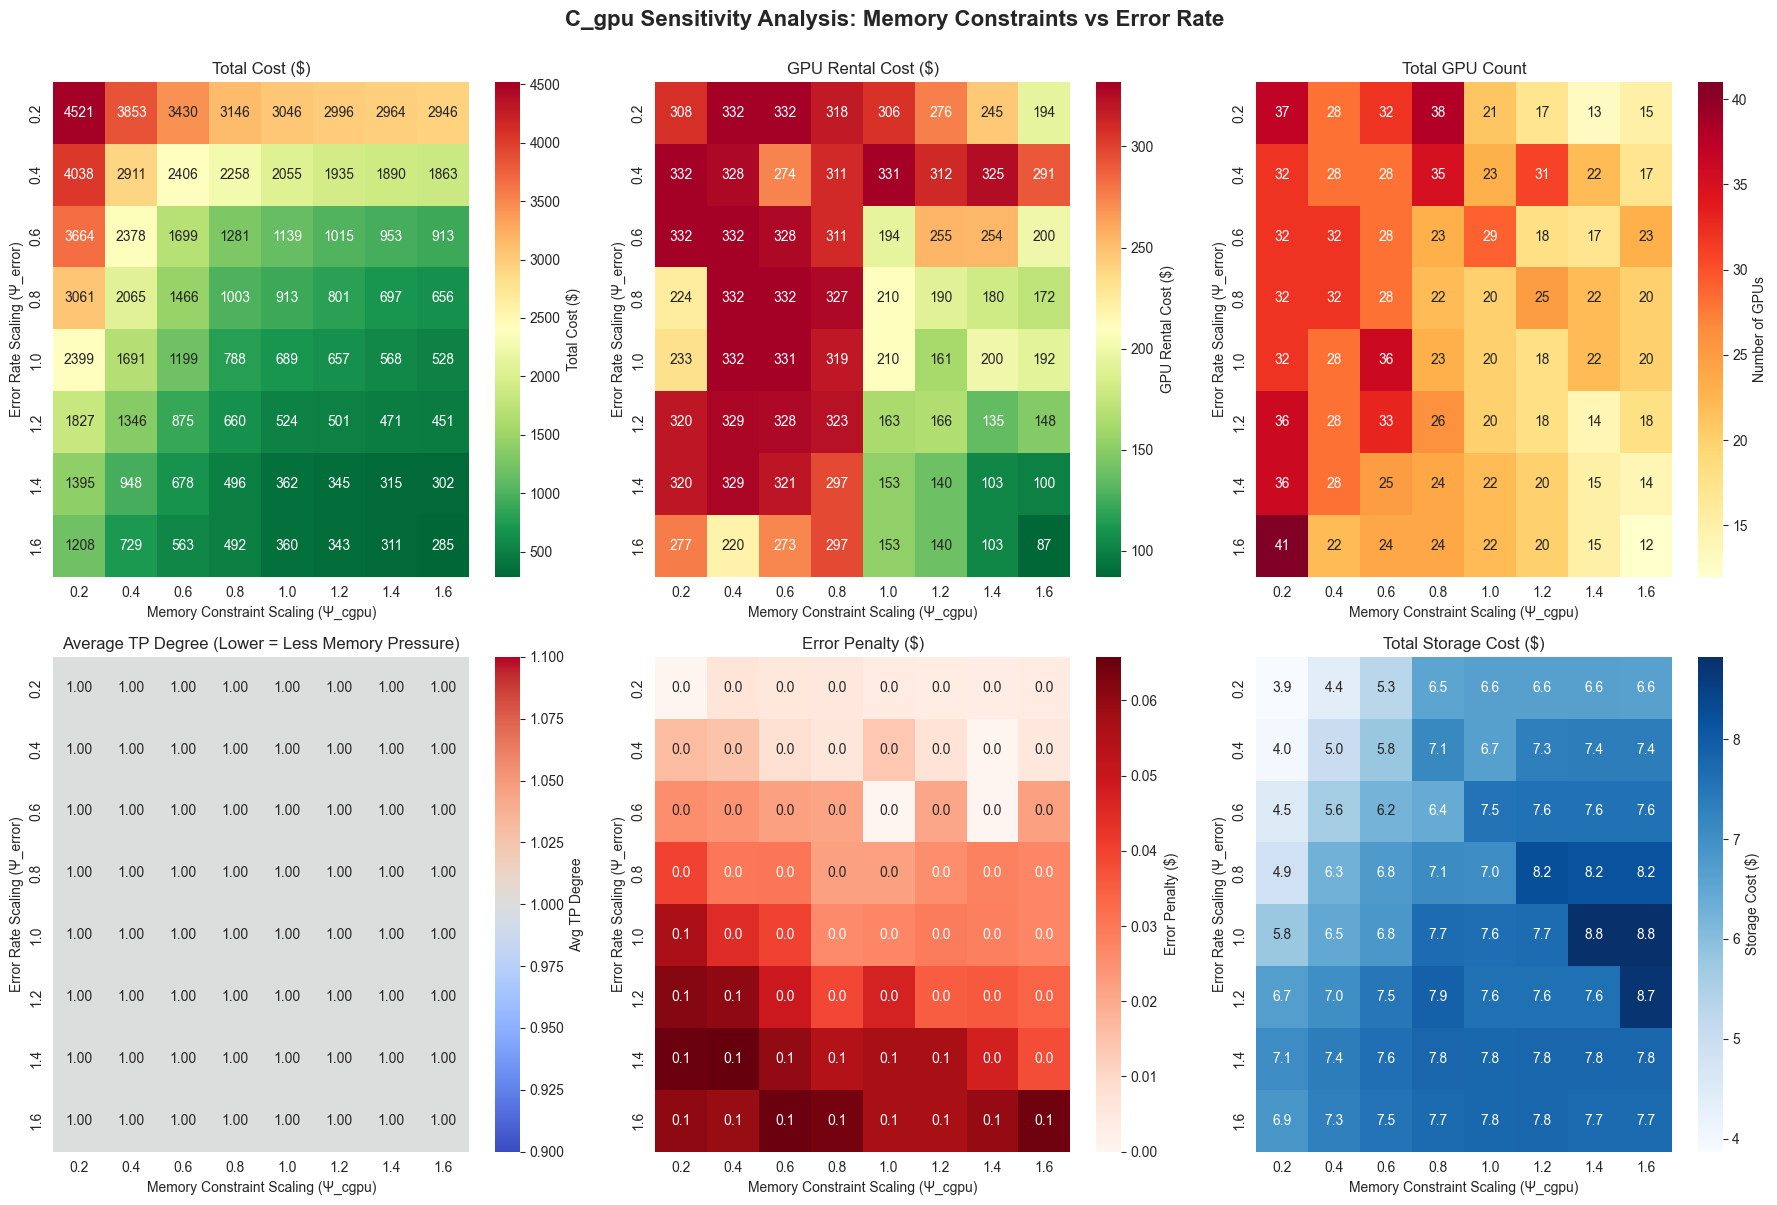

In [ ]:
# Visualization: C_gpu Sensitivity Analysis Results

# Filter successful results for plotting
plot_df = cgpu_results_df[cgpu_results_df['status'].isin(['OPTIMAL', 'TIME_LIMIT'])].copy()

if len(plot_df) > 0:
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('C_gpu Sensitivity Analysis: Memory Constraints vs Error Rate', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # 1. Total Cost Heatmap
    pivot_cost = plot_df.pivot_table(values='total_cost', 
                                      index='psi_error', 
                                      columns='psi_cgpu', 
                                      aggfunc='mean')
    sns.heatmap(pivot_cost, annot=True, fmt='.0f', cmap='RdYlGn_r', 
                ax=axes[0, 0], cbar_kws={'label': 'Total Cost ($)'})
    axes[0, 0].set_title('Total Cost ($)')
    axes[0, 0].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[0, 0].set_ylabel('Error Rate Scaling (Ψ_error)')
    
    # 2. GPU Rental Cost Heatmap
    pivot_gpu_cost = plot_df.pivot_table(values='gpu_rental_cost', 
                                          index='psi_error', 
                                          columns='psi_cgpu', 
                                          aggfunc='mean')
    sns.heatmap(pivot_gpu_cost, annot=True, fmt='.0f', cmap='RdYlGn_r', 
                ax=axes[0, 1], cbar_kws={'label': 'GPU Rental Cost ($)'})
    axes[0, 1].set_title('GPU Rental Cost ($)')
    axes[0, 1].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[0, 1].set_ylabel('Error Rate Scaling (Ψ_error)')
    
    # 3. Total GPUs Heatmap
    pivot_gpus = plot_df.pivot_table(values='total_gpus', 
                                      index='psi_error', 
                                      columns='psi_cgpu', 
                                      aggfunc='mean')
    sns.heatmap(pivot_gpus, annot=True, fmt='.0f', cmap='YlOrRd', 
                ax=axes[0, 2], cbar_kws={'label': 'Number of GPUs'})
    axes[0, 2].set_title('Total GPU Count')
    axes[0, 2].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[0, 2].set_ylabel('Error Rate Scaling (Ψ_error)')
    
    # 4. Average TP Degree Heatmap (KEY METRIC for C_gpu analysis)
    pivot_tp = plot_df.pivot_table(values='avg_tp_degree', 
                                    index='psi_error', 
                                    columns='psi_cgpu', 
                                    aggfunc='mean')
    sns.heatmap(pivot_tp, annot=True, fmt='.2f', cmap='coolwarm', 
                ax=axes[1, 0], cbar_kws={'label': 'Avg TP Degree'})
    axes[1, 0].set_title('Average TP Degree (Lower = Less Memory Pressure)')
    axes[1, 0].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[1, 0].set_ylabel('Error Rate Scaling (Ψ_error)')
    
    # 5. Error Penalty Heatmap
    pivot_error_penalty = plot_df.pivot_table(values='error_penalty', 
                                               index='psi_error', 
                                               columns='psi_cgpu', 
                                               aggfunc='mean')
    sns.heatmap(pivot_error_penalty, annot=True, fmt='.1f', cmap='Reds', 
                ax=axes[1, 1], cbar_kws={'label': 'Error Penalty ($)'})
    axes[1, 1].set_title('Error Penalty ($)')
    axes[1, 1].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[1, 1].set_ylabel('Error Rate Scaling (Ψ_error)')
    
    # 6. Storage Cost Heatmap
    pivot_storage = plot_df.pivot_table(values='storage_cost_total', 
                                         index='psi_error', 
                                         columns='psi_cgpu', 
                                         aggfunc='mean')
    sns.heatmap(pivot_storage, annot=True, fmt='.1f', cmap='Blues', 
                ax=axes[1, 2], cbar_kws={'label': 'Storage Cost ($)'})
    axes[1, 2].set_title('Total Storage Cost ($)')
    axes[1, 2].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[1, 2].set_ylabel('Error Rate Scaling (Ψ_error)')
    
    plt.tight_layout()
    
    # Save figure to sensitivity_results subfolder
    figure_filename = os.path.join(output_dir, f'cgpu_sensitivity_heatmaps_{timestamp}.png')
    plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
    print(f"\nHeatmaps saved to: {figure_filename}")
    plt.show()
    
else:
    print("No successful results to plot!")

Trend plots saved to: sensitivity_results/cgpu_sensitivity_trends_20251022_143003.png


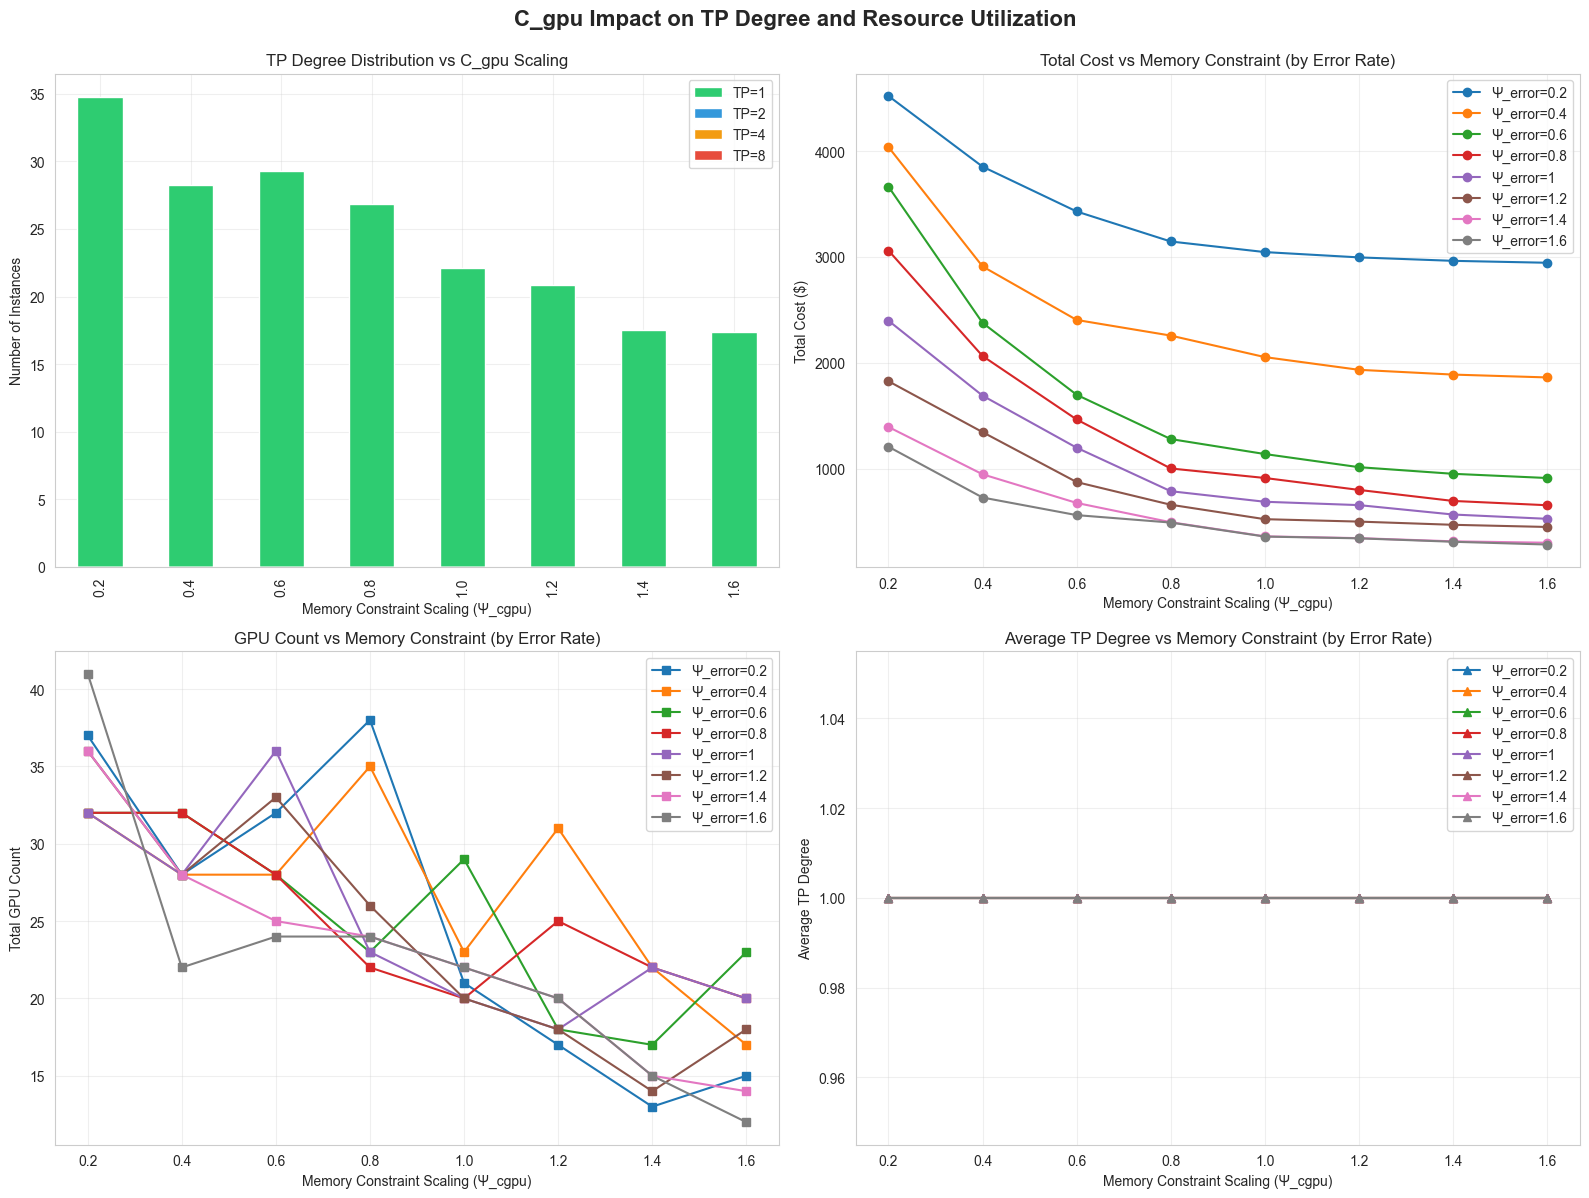

In [ ]:
# Additional Visualizations: TP Degree Distribution and Trend Analysis

if len(plot_df) > 0:
    # Create figure with additional analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('C_gpu Impact on TP Degree and Resource Utilization', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # 1. TP Degree Distribution by C_gpu scaling (stacked bar)
    tp_dist_data = plot_df.groupby('psi_cgpu')[['tp_degree_1', 'tp_degree_2', 
                                                  'tp_degree_4', 'tp_degree_8']].mean()
    tp_dist_data.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                      color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c'])
    axes[0, 0].set_title('TP Degree Distribution vs C_gpu Scaling')
    axes[0, 0].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[0, 0].set_ylabel('Number of Instances')
    axes[0, 0].legend(['TP=1', 'TP=2', 'TP=4', 'TP=8'], loc='upper right')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Cost vs C_gpu for different error rates
    for psi_e in psi_cgpu_values:
        subset = plot_df[plot_df['psi_error'] == psi_e]
        if len(subset) > 0:
            axes[0, 1].plot(subset['psi_cgpu'], subset['total_cost'], 
                           marker='o', label=f'Ψ_error={psi_e}')
    axes[0, 1].set_title('Total Cost vs Memory Constraint (by Error Rate)')
    axes[0, 1].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[0, 1].set_ylabel('Total Cost ($)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. GPU Count vs C_gpu for different error rates
    for psi_e in psi_cgpu_values:
        subset = plot_df[plot_df['psi_error'] == psi_e]
        if len(subset) > 0:
            axes[1, 0].plot(subset['psi_cgpu'], subset['total_gpus'], 
                           marker='s', label=f'Ψ_error={psi_e}')
    axes[1, 0].set_title('GPU Count vs Memory Constraint (by Error Rate)')
    axes[1, 0].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[1, 0].set_ylabel('Total GPU Count')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Average TP Degree vs C_gpu for different error rates
    for psi_e in psi_error_values:
        subset = plot_df[plot_df['psi_error'] == psi_e]
        if len(subset) > 0:
            axes[1, 1].plot(subset['psi_cgpu'], subset['avg_tp_degree'], 
                           marker='^', label=f'Ψ_error={psi_e}')
    axes[1, 1].set_title('Average TP Degree vs Memory Constraint (by Error Rate)')
    axes[1, 1].set_xlabel('Memory Constraint Scaling (Ψ_cgpu)')
    axes[1, 1].set_ylabel('Average TP Degree')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure to sensitivity_results subfolder
    figure_filename = os.path.join(output_dir, f'cgpu_sensitivity_trends_{timestamp}.png')
    plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
    print(f"Trend plots saved to: {figure_filename}")
    plt.show()
    
else:
    print("No successful results to plot!")

# Senstivity anslysis on the budget scaling and the rental cost

In [ ]:
# Budget and rental cost sensitivity analysis functions

def run_budget_cost_sensitivity_analysis(psi_budget, psi_cost, base_data, time_limit=300, mip_gap=0.01):
    """
    Run optimization with scaled budget and rental cost.
    
    Args:
        psi_budget: Scaling factor for budget constraint
        psi_cost: Scaling factor for GPU rental costs
        base_data: Base data object with original parameters
        time_limit: Optimization time limit in seconds
        mip_gap: MIP gap tolerance
    
    Returns:
        Dictionary with results including costs, allocations, and economic metrics
    """
    # Create a copy of data with scaled parameters
    data = copy.deepcopy(base_data)
    
    # Scale budget and rental costs
    data.delta = base_data.delta * psi_budget
    data.p_c = base_data.p_c * psi_cost
    
    # Build and solve optimization
    start_time = time.time()
    try:
        optimizer = LLMInferenceOptimizer(data)
        solution = optimizer.build_and_solve_optimization_problem(time_limit=time_limit, mip_gap=mip_gap)
        solve_time = time.time() - start_time
        
        if solution is None or solution['status'] not in ['OPTIMAL', 'TIME_LIMIT']:
            return {
                'psi_budget': psi_budget,
                'psi_cost': psi_cost,
                'status': 'INFEASIBLE' if solution is None else solution.get('status', 'INFEASIBLE'),
                'solve_time': solve_time
            }
        
        # Extract detailed metrics including economic analysis
        results = extract_budget_cost_metrics(optimizer, solution, data, psi_budget, psi_cost, solve_time)
        return results
        
    except Exception as e:
        print(f"Error for psi_budget={psi_budget}, psi_cost={psi_cost}: {str(e)}")
        return {
            'psi_budget': psi_budget,
            'psi_cost': psi_cost,
            'status': 'ERROR',
            'error_message': str(e),
            'solve_time': time.time() - start_time
        }


def extract_budget_cost_metrics(optimizer, solution, data, psi_budget, psi_cost, solve_time):
    """Extract detailed metrics from solution, focusing on economic trade-offs."""
    
    # Cost components
    C1 = sum(data.Delta_T * data.p_c[k] * y_val for (j, k), y_val in solution['y'].items())
    
    C2_model = 0
    C2_data = 0
    for i in range(data.I):
        for j in range(data.J):
            for k in range(data.K):
                x_val = solution['x'].get((i, j, k), 0)
                if x_val > 0:
                    z_val = optimizer.vars['z'][i, j, k].X
                    C2_model += data.Delta_T * data.p_s * data.B[j] * z_val
                    C2_data += data.Delta_T * data.p_s * data.theta[i] * (data.h[i] + data.f[i]) * data.lambda_i[i] * x_val
    
    C4 = sum(data.phi[i] * u_val * data.lambda_i[i] for i, u_val in solution['u'].items())
    
    varrho_val = optimizer.vars['varrho'].X if hasattr(optimizer.vars['varrho'], 'X') else 0
    
    # GPU tier distribution - key for cost sensitivity
    gpu_tier_allocation = {}
    gpu_tier_cost = {}
    
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            gpu_tier = data.gpu_tiers[k]
            if gpu_tier not in gpu_tier_allocation:
                gpu_tier_allocation[gpu_tier] = 0
                gpu_tier_cost[gpu_tier] = 0
            gpu_tier_allocation[gpu_tier] += y_val
            gpu_tier_cost[gpu_tier] += data.Delta_T * data.p_c[k] * y_val
    
    # Calculate average GPU cost
    total_gpus = sum(solution['y'].values())
    avg_gpu_cost = C1 / total_gpus if total_gpus > 0 else 0
    
    # Precision distribution
    precision_dist = {'FP16': 0, 'INT8': 0, 'INT4': 0}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            gpu_name = data.gpu_tiers[k]
            if 'FP16' in gpu_name:
                precision_dist['FP16'] += y_val
            elif 'INT8' in gpu_name:
                precision_dist['INT8'] += y_val
            elif 'INT4' in gpu_name:
                precision_dist['INT4'] += y_val
    
    # Model distribution
    model_instances = {}
    for (j, k), y_val in solution['y'].items():
        if y_val > 0:
            model = data.model_names[j]
            if model not in model_instances:
                model_instances[model] = 0
            model_instances[model] += y_val
    
    # Unmet demand metrics
    total_unmet = sum(solution['u'].values())
    unmet_percentage = 0
    total_demand = sum(data.lambda_i)
    if total_demand > 0:
        unmet_percentage = (total_unmet / total_demand) * 100
    
    # Budget utilization
    actual_budget = data.delta
    budget_used = C1 + C2_model + C2_data
    budget_utilization = (budget_used / actual_budget * 100) if actual_budget > 0 else 0
    budget_slack = actual_budget - budget_used
    
    return {
        'psi_budget': psi_budget,
        'psi_cost': psi_cost,
        'status': solution['status'],
        'solve_time': solve_time,
        'total_cost': solution['objective'],
        'gpu_rental_cost': C1,
        'storage_cost_model': C2_model,
        'storage_cost_data': C2_data,
        'storage_cost_total': C2_model + C2_data,
        'delay_penalty': varrho_val,
        'unmet_demand_penalty': C4,
        'total_gpus': total_gpus,
        'avg_gpu_cost': avg_gpu_cost,
        # Budget metrics (key for budget sensitivity)
        'budget_available': actual_budget,
        'budget_used': budget_used,
        'budget_utilization_pct': budget_utilization,
        'budget_slack': budget_slack,
        # GPU tier metrics (key for cost sensitivity)
        'precision_FP16': precision_dist['FP16'],
        'precision_INT8': precision_dist['INT8'],
        'precision_INT4': precision_dist['INT4'],
        # Service quality metrics
        'total_unmet_demand': total_unmet,
        'unmet_demand_pct': unmet_percentage,
        'num_active_configs': len(solution['y']),
        'gpu_tier_allocation': gpu_tier_allocation,
        'gpu_tier_cost': gpu_tier_cost,
        'model_instances': model_instances
    }

print("Budget/cost sensitivity analysis functions defined successfully!")

Budget/cost sensitivity analysis functions defined successfully!


In [ ]:
# Run budget/cost sensitivity analysis

# Define scaling factors
psi_budget_values = [0.2,0.4,0.6,0.8,1]
psi_cost_values = [0.2,0.4,0.6,0.8,1,1.2,1.4]

# Save base values
base_budget = base_data.delta
base_costs = base_data.p_c.copy()

print("="*80)
print("BUDGET/COST SENSITIVITY ANALYSIS SETUP")
print("="*80)
print(f"Base budget (δ): ${base_budget:.2f}")
print(f"Base GPU costs (p_c): {[f'${c:.2f}' for c in base_costs]}")
print(f"\nBudget scaling factors: {psi_budget_values}")
print(f"Cost scaling factors: {psi_cost_values}")

# Storage for results
budget_cost_results_list = []

# Run sensitivity analysis
print("\n" + "="*80)
print("Starting budget/cost sensitivity analysis...")
print("="*80)

counter = 0
total = len(psi_budget_values) * len(psi_cost_values)

for psi_budget in psi_budget_values:
    for psi_cost in psi_cost_values:
        counter += 1
        print(f"\n[{counter}/{total}] psi_budget={psi_budget:.2f}, psi_cost={psi_cost:.2f}")
        
        # Run analysis for this pair
        result = run_budget_cost_sensitivity_analysis(psi_budget, psi_cost, base_data,
                                                       time_limit=300, mip_gap=0.01)
        budget_cost_results_list.append(result)
        
        # Display key results
        if result['status'] in ['OPTIMAL', 'TIME_LIMIT']:
            print(f"  ✓ Status: {result['status']}")
            print(f"    Total Cost: ${result['total_cost']:.2f}")
            print(f"    GPU Rental: ${result['gpu_rental_cost']:.2f}")
            print(f"    Total GPUs: {result['total_gpus']:.0f}")
            print(f"    Budget Utilization: {result['budget_utilization_pct']:.1f}%")
            print(f"    Unmet Demand: {result['unmet_demand_pct']:.1f}%")
        else:
            print(f"  ✗ Status: {result['status']}")

print("\n" + "="*80)
print("Budget/cost sensitivity analysis completed!")
print("="*80)

# Convert to DataFrame
budget_cost_df = pd.DataFrame(budget_cost_results_list)

# Display summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
successful = budget_cost_df[budget_cost_df['status'].isin(['OPTIMAL', 'TIME_LIMIT'])]
print(f"Total scenarios: {len(budget_cost_df)}")
print(f"Successful: {len(successful)}")
print(f"Infeasible: {sum(budget_cost_df['status'] == 'INFEASIBLE')}")
print(f"Errors: {sum(budget_cost_df['status'] == 'ERROR')}")

if len(successful) > 0:
    print(f"\nCost Statistics:")
    print(f"  Min: ${successful['total_cost'].min():.2f}")
    print(f"  Max: ${successful['total_cost'].max():.2f}")
    print(f"  Mean: ${successful['total_cost'].mean():.2f}")
    
    print(f"\nBudget Utilization:")
    print(f"  Min: {successful['budget_utilization_pct'].min():.1f}%")
    print(f"  Max: {successful['budget_utilization_pct'].max():.1f}%")
    print(f"  Mean: {successful['budget_utilization_pct'].mean():.1f}%")
    
    print(f"\nUnmet Demand:")
    print(f"  Min: {successful['unmet_demand_pct'].min():.1f}%")
    print(f"  Max: {successful['unmet_demand_pct'].max():.1f}%")
    print(f"  Mean: {successful['unmet_demand_pct'].mean():.1f}%")

# Display sample results
print("\n" + "="*80)
print("SAMPLE RESULTS")
print("="*80)

# Check which columns are available
available_cols = budget_cost_df.columns.tolist()
desired_cols = ['psi_budget', 'psi_cost', 'total_cost', 'gpu_rental_cost',
                'total_gpus', 'budget_utilization_pct', 'unmet_demand_pct', 'status']
display_cols = [col for col in desired_cols if col in available_cols]

if len(successful) > 0 and all(col in available_cols for col in ['total_cost', 'gpu_rental_cost']):
    print(budget_cost_df[display_cols].head(10))
else:
    print("No successful optimization results with detailed metrics.")
    print("\nShowing status summary:")
    print(budget_cost_df[['psi_budget', 'psi_cost', 'status']].head(10))

BUDGET/COST SENSITIVITY ANALYSIS SETUP
Base budget (δ): $5000.00
Base GPU costs (p_c): ['$0.64', '$0.55', '$2.46', '$0.61', '$0.30', '$0.37', '$0.99', '$1.31', '$2.35', '$2.00']

Budget scaling factors: [0.2, 0.4, 0.6, 0.8, 1]
Cost scaling factors: [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

Starting budget/cost sensitivity analysis...

[1/50] psi_budget=0.20, psi_cost=0.20
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ Status: OPTIMAL
    Total Cost: $218.17
    GPU Rental: $77.07
    Total GPUs: 15
    Budget Utilization: 12.2%
    Unmet Demand: 0.0%

[2/50] psi_budget=0.20, psi_cost=0.40
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ Status: OPTIMAL
    Total Cost: $287.06
    GPU Rental: $137.33
    Total GPUs: 17
    Budget Utilization: 18.3%
    Unmet Demand: 0.0%

[3/50] psi_budget=0.20, psi_cost=0.60
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ Status: OPTIMAL
    Total Cost: $1319.33
 

In [ ]:
# Save budget/cost sensitivity analysis results

# Save to CSV
csv_filename = os.path.join(output_dir, f'budget_cost_sensitivity_{timestamp}.csv')
budget_cost_df.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")

Results saved to: sensitivity_results/budget_cost_sensitivity_20251026_010257.csv



Heatmaps saved to: sensitivity_results/budget_cost_heatmaps_20251026_010257.png


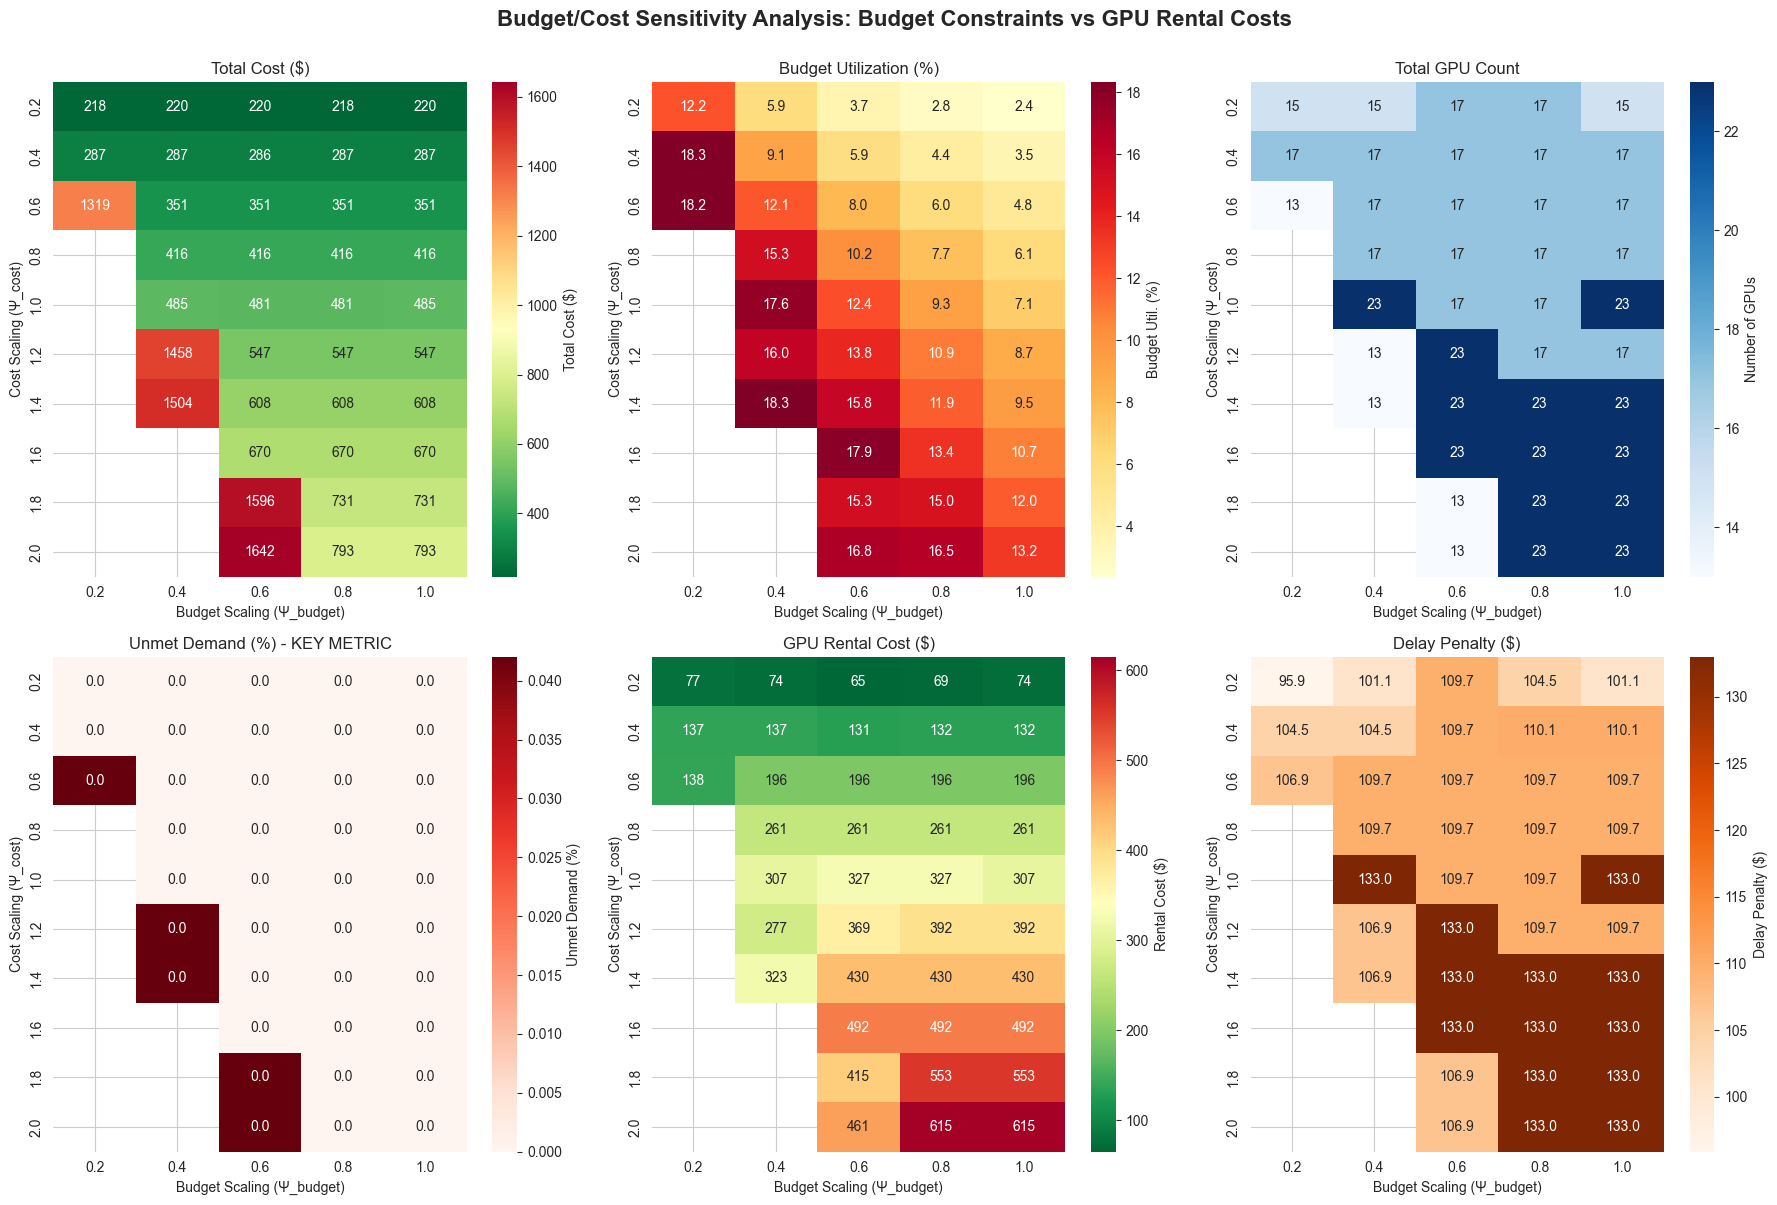

In [ ]:
# Visualization: Budget/Cost Sensitivity Analysis Results

# Filter successful results
plot_df = budget_cost_df[budget_cost_df['status'].isin(['OPTIMAL', 'TIME_LIMIT'])].copy()

if len(plot_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Budget/Cost Sensitivity Analysis: Budget Constraints vs GPU Rental Costs',
                 fontsize=16, fontweight='bold', y=1.00)
    
    # 1. Total Cost Heatmap
    pivot_cost = plot_df.pivot_table(values='total_cost',
                                      index='psi_cost',
                                      columns='psi_budget',
                                      aggfunc='mean')
    sns.heatmap(pivot_cost, annot=True, fmt='.0f', cmap='RdYlGn_r',
                ax=axes[0, 0], cbar_kws={'label': 'Total Cost ($)'})
    axes[0, 0].set_title('Total Cost ($)')
    axes[0, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 0].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 2. Budget Utilization Heatmap
    pivot_budget_util = plot_df.pivot_table(values='budget_utilization_pct',
                                              index='psi_cost',
                                              columns='psi_budget',
                                              aggfunc='mean')
    sns.heatmap(pivot_budget_util, annot=True, fmt='.1f', cmap='YlOrRd',
                ax=axes[0, 1], cbar_kws={'label': 'Budget Util. (%)'})
    axes[0, 1].set_title('Budget Utilization (%)')
    axes[0, 1].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 1].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 3. Total GPUs Heatmap
    pivot_gpus = plot_df.pivot_table(values='total_gpus',
                                      index='psi_cost',
                                      columns='psi_budget',
                                      aggfunc='mean')
    sns.heatmap(pivot_gpus, annot=True, fmt='.0f', cmap='Blues',
                ax=axes[0, 2], cbar_kws={'label': 'Number of GPUs'})
    axes[0, 2].set_title('Total GPU Count')
    axes[0, 2].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 2].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 4. Unmet Demand Heatmap (KEY METRIC)
    pivot_unmet = plot_df.pivot_table(values='unmet_demand_pct',
                                       index='psi_cost',
                                       columns='psi_budget',
                                       aggfunc='mean')
    sns.heatmap(pivot_unmet, annot=True, fmt='.1f', cmap='Reds',
                ax=axes[1, 0], cbar_kws={'label': 'Unmet Demand (%)'})
    axes[1, 0].set_title('Unmet Demand (%) - KEY METRIC')
    axes[1, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 0].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 5. GPU Rental Cost Heatmap
    pivot_rental = plot_df.pivot_table(values='gpu_rental_cost',
                                        index='psi_cost',
                                        columns='psi_budget',
                                        aggfunc='mean')
    sns.heatmap(pivot_rental, annot=True, fmt='.0f', cmap='RdYlGn_r',
                ax=axes[1, 1], cbar_kws={'label': 'Rental Cost ($)'})
    axes[1, 1].set_title('GPU Rental Cost ($)')
    axes[1, 1].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 1].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 6. Delay Penalty Heatmap
    pivot_delay = plot_df.pivot_table(values='delay_penalty',
                                       index='psi_cost',
                                       columns='psi_budget',
                                       aggfunc='mean')
    sns.heatmap(pivot_delay, annot=True, fmt='.1f', cmap='Oranges',
                ax=axes[1, 2], cbar_kws={'label': 'Delay Penalty ($)'})
    axes[1, 2].set_title('Delay Penalty ($)')
    axes[1, 2].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 2].set_ylabel('Cost Scaling (Ψ_cost)')
    
    plt.tight_layout()
    
    # Save figure
    figure_filename = os.path.join(output_dir, f'budget_cost_heatmaps_{timestamp}.png')
    plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
    print(f"\nHeatmaps saved to: {figure_filename}")
    plt.show()
    
else:
    print("No successful results to plot!")

Trend plots saved to: sensitivity_results/budget_cost_trends_20251022_153059.png


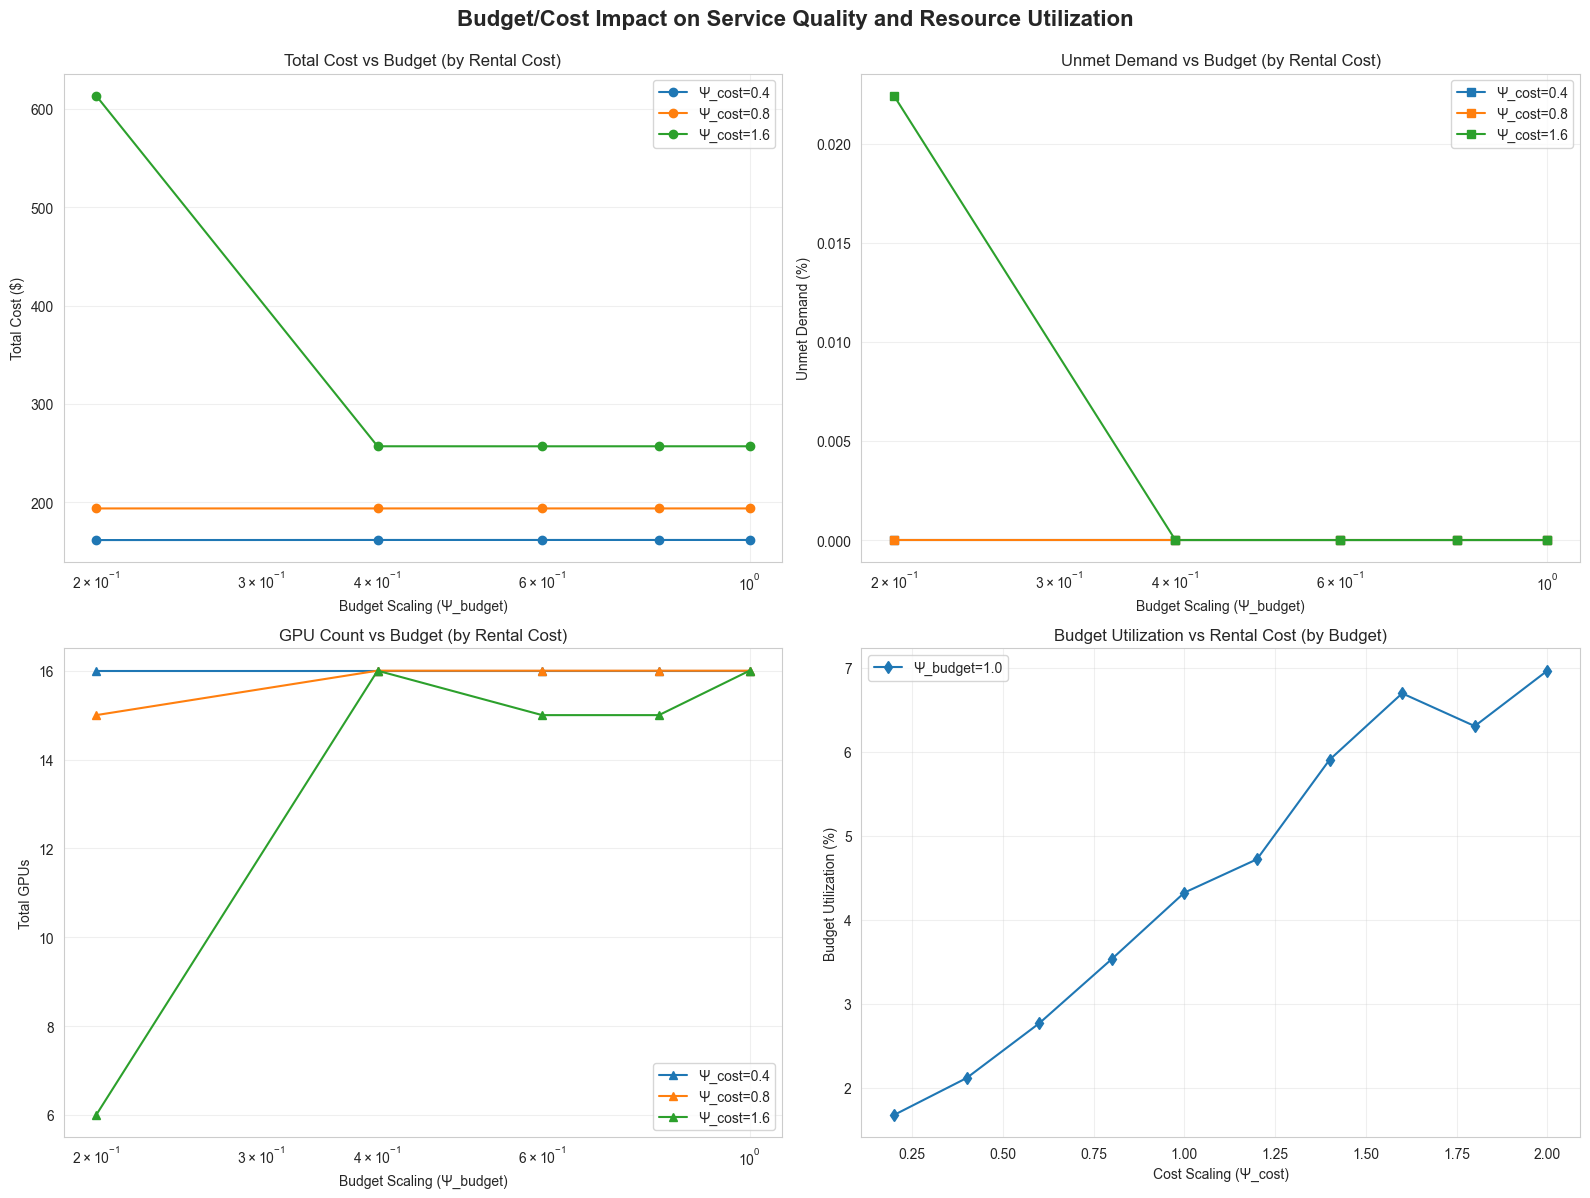

In [ ]:
# Additional Visualizations: Budget/Cost Trade-off Trends

if len(plot_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Budget/Cost Impact on Service Quality and Resource Utilization',
                 fontsize=16, fontweight='bold', y=0.995)
    
    # 1. Total Cost vs Budget for different cost levels
    for psi_c in [0.4, 0.8, 1.6, 2.4, 3.0]:
        subset = plot_df[plot_df['psi_cost'] == psi_c]
        if len(subset) > 0:
            axes[0, 0].plot(subset['psi_budget'], subset['total_cost'],
                           marker='o', label=f'Ψ_cost={psi_c}')
    axes[0, 0].set_title('Total Cost vs Budget (by Rental Cost)')
    axes[0, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 0].set_ylabel('Total Cost ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xscale('log')
    
    # 2. Unmet Demand vs Budget for different cost levels
    for psi_c in [0.4, 0.8, 1.6, 2.4, 3.0]:
        subset = plot_df[plot_df['psi_cost'] == psi_c]
        if len(subset) > 0:
            axes[0, 1].plot(subset['psi_budget'], subset['unmet_demand_pct'],
                           marker='s', label=f'Ψ_cost={psi_c}')
    axes[0, 1].set_title('Unmet Demand vs Budget (by Rental Cost)')
    axes[0, 1].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 1].set_ylabel('Unmet Demand (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xscale('log')
    
    # 3. GPU Count vs Budget for different cost levels
    for psi_c in [0.4, 0.8, 1.6, 2.4, 3.0]:
        subset = plot_df[plot_df['psi_cost'] == psi_c]
        if len(subset) > 0:
            axes[1, 0].plot(subset['psi_budget'], subset['total_gpus'],
                           marker='^', label=f'Ψ_cost={psi_c}')
    axes[1, 0].set_title('GPU Count vs Budget (by Rental Cost)')
    axes[1, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 0].set_ylabel('Total GPUs')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xscale('log')
    
    # 4. Budget Utilization vs Cost for different budget levels
    for psi_b in [0.01, 0.05, 0.1, 0.5, 1.0]:
        subset = plot_df[plot_df['psi_budget'] == psi_b]
        if len(subset) > 0:
            axes[1, 1].plot(subset['psi_cost'], subset['budget_utilization_pct'],
                           marker='d', label=f'Ψ_budget={psi_b}')
    axes[1, 1].set_title('Budget Utilization vs Rental Cost (by Budget)')
    axes[1, 1].set_xlabel('Cost Scaling (Ψ_cost)')
    axes[1, 1].set_ylabel('Budget Utilization (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    figure_filename = os.path.join(output_dir, f'budget_cost_trends_{timestamp}.png')
    plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
    print(f"Trend plots saved to: {figure_filename}")
    plt.show()
    
else:
    print("No successful results to plot!")

In [ ]:
from parameter_setup import ParameterGenerator, RobustLLMInferenceData
from RDDU_LLM_inference_opt import LLMInferenceOptimizer


# Generate the base data using ParameterGenerator from parameter_setup
generator = ParameterGenerator(seed=42)

# Generate all parameters
I, J, K, N, TP_degrees = generator.get_problem_dimensions()
query_types = generator.get_query_types()
model_names = generator.get_model_names()
gpu_tiers = generator.get_gpu_tiers()
B = generator.get_model_sizes()
h = generator.get_input_token_lengths()
f = generator.get_output_token_lengths()
C_gpu = generator.get_gpu_memory_capacities()
P_gpu = generator.get_gpu_compute_powers()
beta = generator.get_kv_cache_consumption()
delta, Delta_T, Delta_i, epsilon, C_storage = generator.get_thresholds()

# Generate random parameters
lambda_i = generator.generate_arrival_rates()
p_c = generator.generate_gpu_costs()
p_s = generator.generate_storage_cost()
alpha = generator.generate_compute_consumption()
theta = generator.generate_token_sizes()
rho = generator.generate_delay_penalties()
phi = generator.generate_unmet_penalties()

# Generate performance matrices
d = generator.generate_processing_delays()
e = generator.generate_error_rates()
d_bar, d_hat = generator.generate_uncertainty_delays(d)
e_bar, e_hat = generator.generate_uncertainty_error_rates(e)
Gamma_d, Gamma_e = generator.generate_uncertainty_budgets(I, J)
gamma_impact = generator.generate_gamma_impact(J, K, model_names, P_gpu)
error_impact = generator.generate_error_impact(J, K, model_names, gpu_tiers, P_gpu)
T_res = generator.generate_residency_times(I, J, K)
BigM = generator.get_bigm_value()

# Create data object
base_data = RobustLLMInferenceData(
    I=I, J=J, K=K, N=N, TP_degrees=TP_degrees, BigM=BigM,
    query_types=query_types, model_names=model_names, gpu_tiers=gpu_tiers,
    B=B, h=h, f=f, lambda_i=lambda_i,
    C_gpu=C_gpu, P_gpu=P_gpu, p_c=p_c,
    C_storage=C_storage, p_s=p_s,
    beta=beta, alpha=alpha, theta=theta,
    rho=rho, phi=phi,
    delta=delta, Delta_T=Delta_T,
    Delta_i=Delta_i, epsilon=epsilon,
    d_bar=d_bar, d_hat=d_hat, e_bar=e_bar, e_hat=e_hat,
    Gamma_d=Gamma_d, Gamma_e=Gamma_e,
    gamma_impact=gamma_impact, error_impact=error_impact, T_res=T_res
)


In [ ]:

psi_budget_values = [0.4,0.6,0.8,1,1.2]
psi_cost_values = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]

# Save base values
base_budget = base_data.delta
base_costs = base_data.p_c.copy()

print("="*80)
print("BUDGET/COST SENSITIVITY ANALYSIS SETUP")
print("="*80)
print(f"Base budget (δ): ${base_budget:.2f}")
print(f"Base GPU costs (p_c): {[f'${c:.2f}' for c in base_costs]}")
print(f"\nBudget scaling factors: {psi_budget_values}")
print(f"Cost scaling factors: {psi_cost_values}")

# Storage for results
budget_cost_results_list = []

# Run sensitivity analysis
print("\n" + "="*80)
print("Starting budget/cost sensitivity analysis...")
print("="*80)

counter = 0
total = len(psi_budget_values) * len(psi_cost_values)

for psi_budget in psi_budget_values:
    for psi_cost in psi_cost_values:
        counter += 1
        print(f"\n[{counter}/{total}] psi_budget={psi_budget:.2f}, psi_cost={psi_cost:.2f}")
        
        # Run analysis for this pair
        result = run_budget_cost_sensitivity_analysis(psi_budget, psi_cost, base_data,
                                                       time_limit=300, mip_gap=0.01)
        budget_cost_results_list.append(result)
        
        # Display key results
        if result['status'] in ['OPTIMAL', 'TIME_LIMIT']:
            print(f"    Status: {result['status']}")
            print(f"    Total Cost: ${result['total_cost']:.2f}")
            print(f"    GPU Rental: ${result['gpu_rental_cost']:.2f}")
            print(f"    Total GPUs: {result['total_gpus']:.0f}")
            print(f"    Delay Penalty: ${result['delay_penalty']:.2f}")
            print(f"    Budget Utilization: {result['budget_utilization_pct']:.1f}%")
            print(f"    Unmet Demand: {result['unmet_demand_pct']:.1f}%")
        else:
            print(f"  ✗ Status: {result['status']}")

print("\n" + "="*80)
print("Budget/cost sensitivity analysis completed!")
print("="*80)

# Convert to DataFrame
budget_cost_df = pd.DataFrame(budget_cost_results_list)

# Display summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
successful = budget_cost_df[budget_cost_df['status'].isin(['OPTIMAL', 'TIME_LIMIT'])]
print(f"Total scenarios: {len(budget_cost_df)}")
print(f"Successful: {len(successful)}")
print(f"Infeasible: {sum(budget_cost_df['status'] == 'INFEASIBLE')}")
print(f"Errors: {sum(budget_cost_df['status'] == 'ERROR')}")

if len(successful) > 0:
    print(f"\nCost Statistics:")
    print(f"  Min: ${successful['total_cost'].min():.2f}")
    print(f"  Max: ${successful['total_cost'].max():.2f}")
    print(f"  Mean: ${successful['total_cost'].mean():.2f}")
    
    print(f"\nBudget Utilization:")
    print(f"  Min: {successful['budget_utilization_pct'].min():.1f}%")
    print(f"  Max: {successful['budget_utilization_pct'].max():.1f}%")
    print(f"  Mean: {successful['budget_utilization_pct'].mean():.1f}%")
    
    print(f"\nUnmet Demand:")
    print(f"  Min: {successful['unmet_demand_pct'].min():.1f}%")
    print(f"  Max: {successful['unmet_demand_pct'].max():.1f}%")
    print(f"  Mean: {successful['unmet_demand_pct'].mean():.1f}%")



# Check which columns are available
available_cols = budget_cost_df.columns.tolist()
desired_cols = ['psi_budget', 'psi_cost', 'total_cost', 'gpu_rental_cost','total_gpus', 'budget_utilization_pct', 'unmet_demand_pct', 'delay_penalty','status']

display_cols = [col for col in desired_cols if col in available_cols]

if len(successful) > 0 and all(col in available_cols for col in ['total_cost', 'gpu_rental_cost']):
    print(budget_cost_df[display_cols].head(10))
else:
    print("No successful optimization results with detailed metrics.")
    print("\nShowing status summary:")
    print(budget_cost_df[['psi_budget', 'psi_cost', 'status']].head(10))

BUDGET/COST SENSITIVITY ANALYSIS SETUP
Base budget (δ): $2000.00
Base GPU costs (p_c): ['$0.64', '$0.55', '$2.46', '$0.61', '$0.30', '$0.37', '$0.99', '$1.31', '$2.35', '$2.00']

Budget scaling factors: [0.4, 0.6, 0.8, 1, 1.2]
Cost scaling factors: [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

Starting budget/cost sensitivity analysis...

[1/50] psi_budget=0.40, psi_cost=0.20
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
    Status: OPTIMAL
    Total Cost: $399.06
    GPU Rental: $94.68
    Total GPUs: 25
    Delay Penalty: $252.84
    Budget Utilization: 12.9%
    Unmet Demand: 0.0%

[2/50] psi_budget=0.40, psi_cost=0.40
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
    Status: OPTIMAL
    Total Cost: $561.19
    GPU Rental: $85.48
    Total GPUs: 20
    Delay Penalty: $264.84
    Budget Utilization: 11.6%
    Unmet Demand: 0.0%

[3/50] psi_budget=0.40, psi_cost=0.60
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to val

In [ ]:
# Save C_gpu sensitivity analysis results to sensitivity_results subfolder
import os
# Create output directory
output_dir = 'sensitivity_results'
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

csv_filename = os.path.join(output_dir, f'budget_cost_sensitivity_{timestamp}.csv')
budget_cost_df.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")

# Save as pickle
pickle_filename = os.path.join(output_dir, f'budget_cost_sensitivity_{timestamp}.pkl')
with open(pickle_filename, 'wb') as f:
    pickle.dump(budget_cost_results_list, f)
print(f"Full results saved to: {pickle_filename}")

Results saved to: sensitivity_results/budget_cost_sensitivity_20251023_132540.csv
Full results saved to: sensitivity_results/budget_cost_sensitivity_20251023_132540.pkl



Heatmaps saved to: sensitivity_results/budget_cost_heatmaps_20251023_132540.png


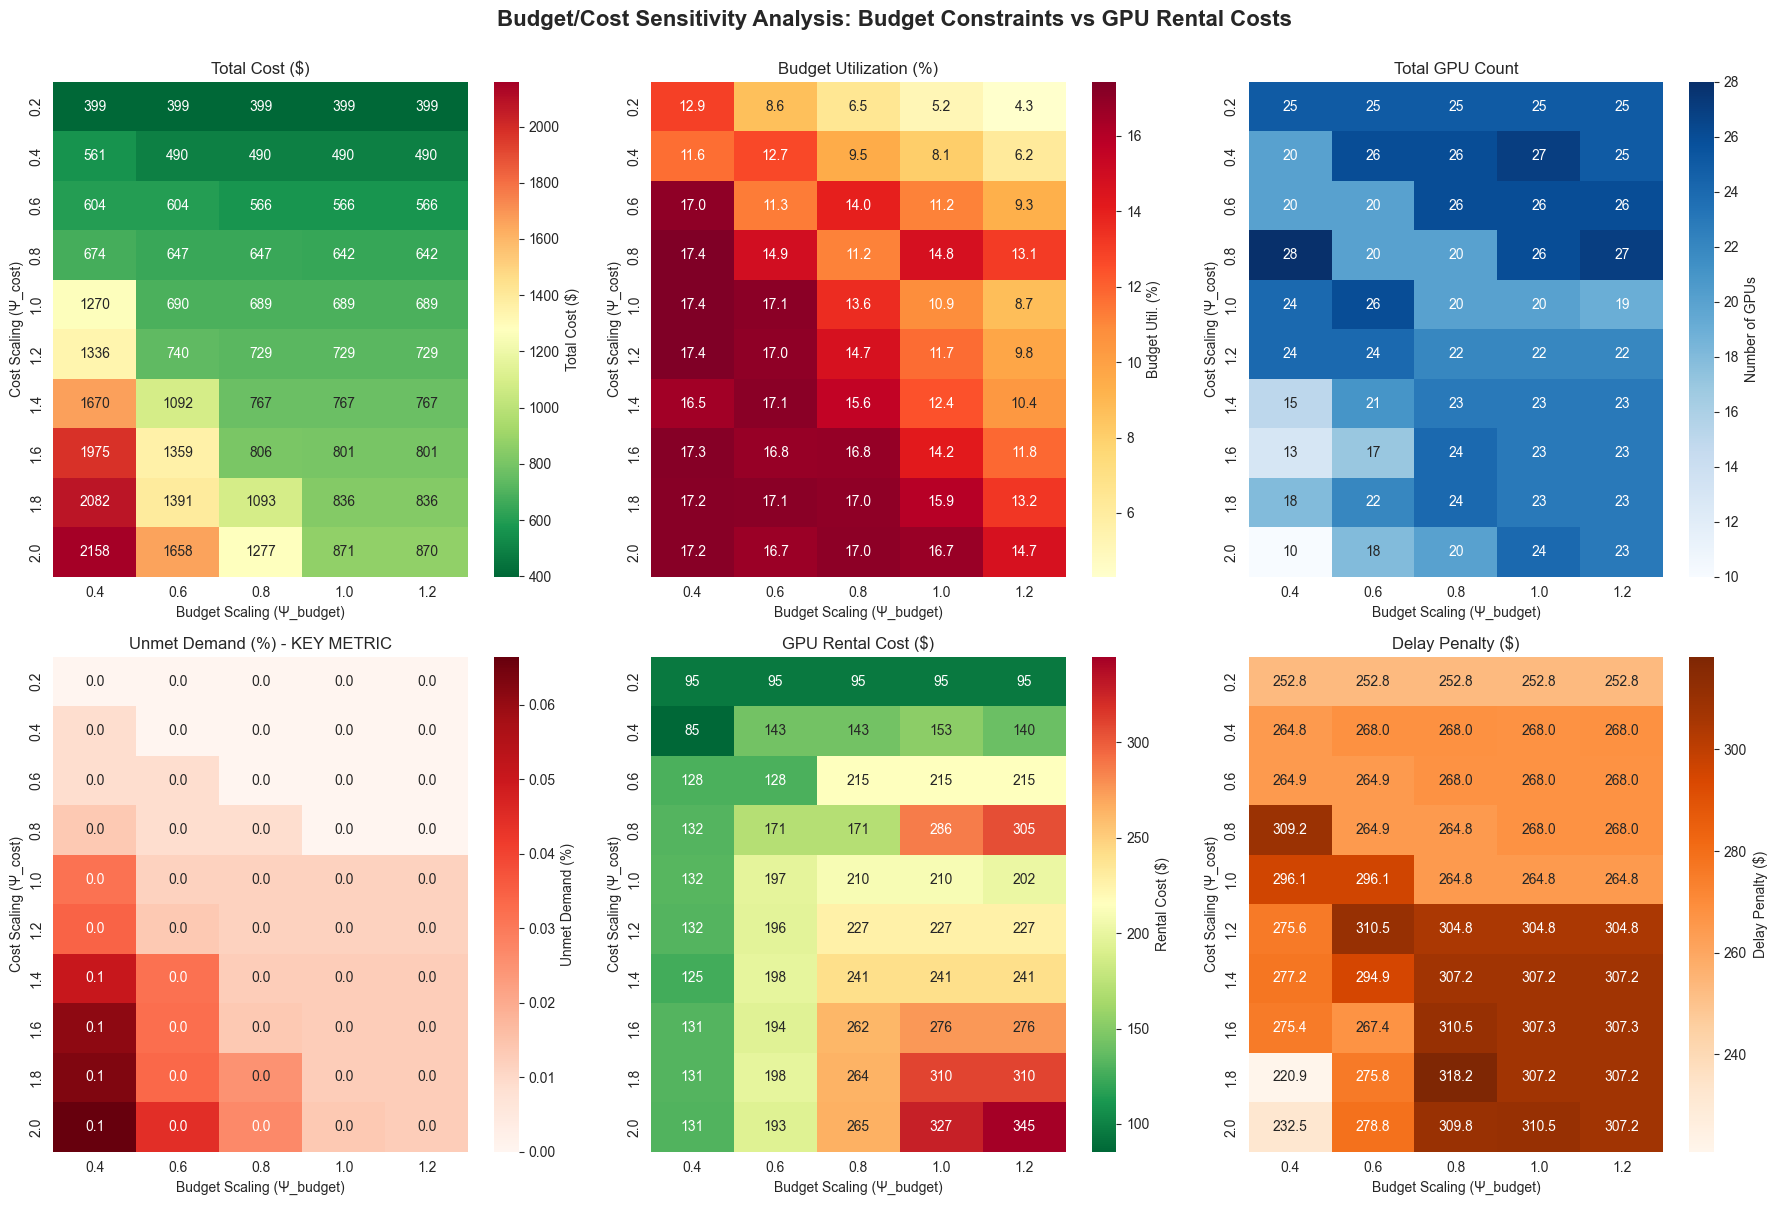

In [ ]:
# Visualization: Budget/Cost Sensitivity Analysis Results

# Filter successful results
plot_df = budget_cost_df[budget_cost_df['status'].isin(['OPTIMAL', 'TIME_LIMIT'])].copy()

if len(plot_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Budget/Cost Sensitivity Analysis: Budget Constraints vs GPU Rental Costs',
                 fontsize=16, fontweight='bold', y=1.00)
    
    # 1. Total Cost Heatmap
    pivot_cost = plot_df.pivot_table(values='total_cost',
                                      index='psi_cost',
                                      columns='psi_budget',
                                      aggfunc='mean')
    sns.heatmap(pivot_cost, annot=True, fmt='.0f', cmap='RdYlGn_r',
                ax=axes[0, 0], cbar_kws={'label': 'Total Cost ($)'})
    axes[0, 0].set_title('Total Cost ($)')
    axes[0, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 0].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 2. Budget Utilization Heatmap
    pivot_budget_util = plot_df.pivot_table(values='budget_utilization_pct',
                                              index='psi_cost',
                                              columns='psi_budget',
                                              aggfunc='mean')
    sns.heatmap(pivot_budget_util, annot=True, fmt='.1f', cmap='YlOrRd',
                ax=axes[0, 1], cbar_kws={'label': 'Budget Util. (%)'})
    axes[0, 1].set_title('Budget Utilization (%)')
    axes[0, 1].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 1].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 3. Total GPUs Heatmap
    pivot_gpus = plot_df.pivot_table(values='total_gpus',
                                      index='psi_cost',
                                      columns='psi_budget',
                                      aggfunc='mean')
    sns.heatmap(pivot_gpus, annot=True, fmt='.0f', cmap='Blues',
                ax=axes[0, 2], cbar_kws={'label': 'Number of GPUs'})
    axes[0, 2].set_title('Total GPU Count')
    axes[0, 2].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 2].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 4. Unmet Demand Heatmap (KEY METRIC)
    pivot_unmet = plot_df.pivot_table(values='unmet_demand_pct',
                                       index='psi_cost',
                                       columns='psi_budget',
                                       aggfunc='mean')
    sns.heatmap(pivot_unmet, annot=True, fmt='.1f', cmap='Reds',
                ax=axes[1, 0], cbar_kws={'label': 'Unmet Demand (%)'})
    axes[1, 0].set_title('Unmet Demand (%) - KEY METRIC')
    axes[1, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 0].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 5. GPU Rental Cost Heatmap
    pivot_rental = plot_df.pivot_table(values='gpu_rental_cost',
                                        index='psi_cost',
                                        columns='psi_budget',
                                        aggfunc='mean')
    sns.heatmap(pivot_rental, annot=True, fmt='.0f', cmap='RdYlGn_r',
                ax=axes[1, 1], cbar_kws={'label': 'Rental Cost ($)'})
    axes[1, 1].set_title('GPU Rental Cost ($)')
    axes[1, 1].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 1].set_ylabel('Cost Scaling (Ψ_cost)')
    
    # 6. Delay Penalty Heatmap
    pivot_delay = plot_df.pivot_table(values='delay_penalty',
                                       index='psi_cost',
                                       columns='psi_budget',
                                       aggfunc='mean')
    sns.heatmap(pivot_delay, annot=True, fmt='.1f', cmap='Oranges',
                ax=axes[1, 2], cbar_kws={'label': 'Delay Penalty ($)'})
    axes[1, 2].set_title('Delay Penalty ($)')
    axes[1, 2].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 2].set_ylabel('Cost Scaling (Ψ_cost)')
    
    plt.tight_layout()
    
    # Save figure
    figure_filename = os.path.join(output_dir, f'budget_cost_heatmaps_{timestamp}.png')
    plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
    print(f"\nHeatmaps saved to: {figure_filename}")
    plt.show()
    
else:
    print("No successful results to plot!")

Trend plots saved to: sensitivity_results/budget_cost_trends_20251023_132540.png


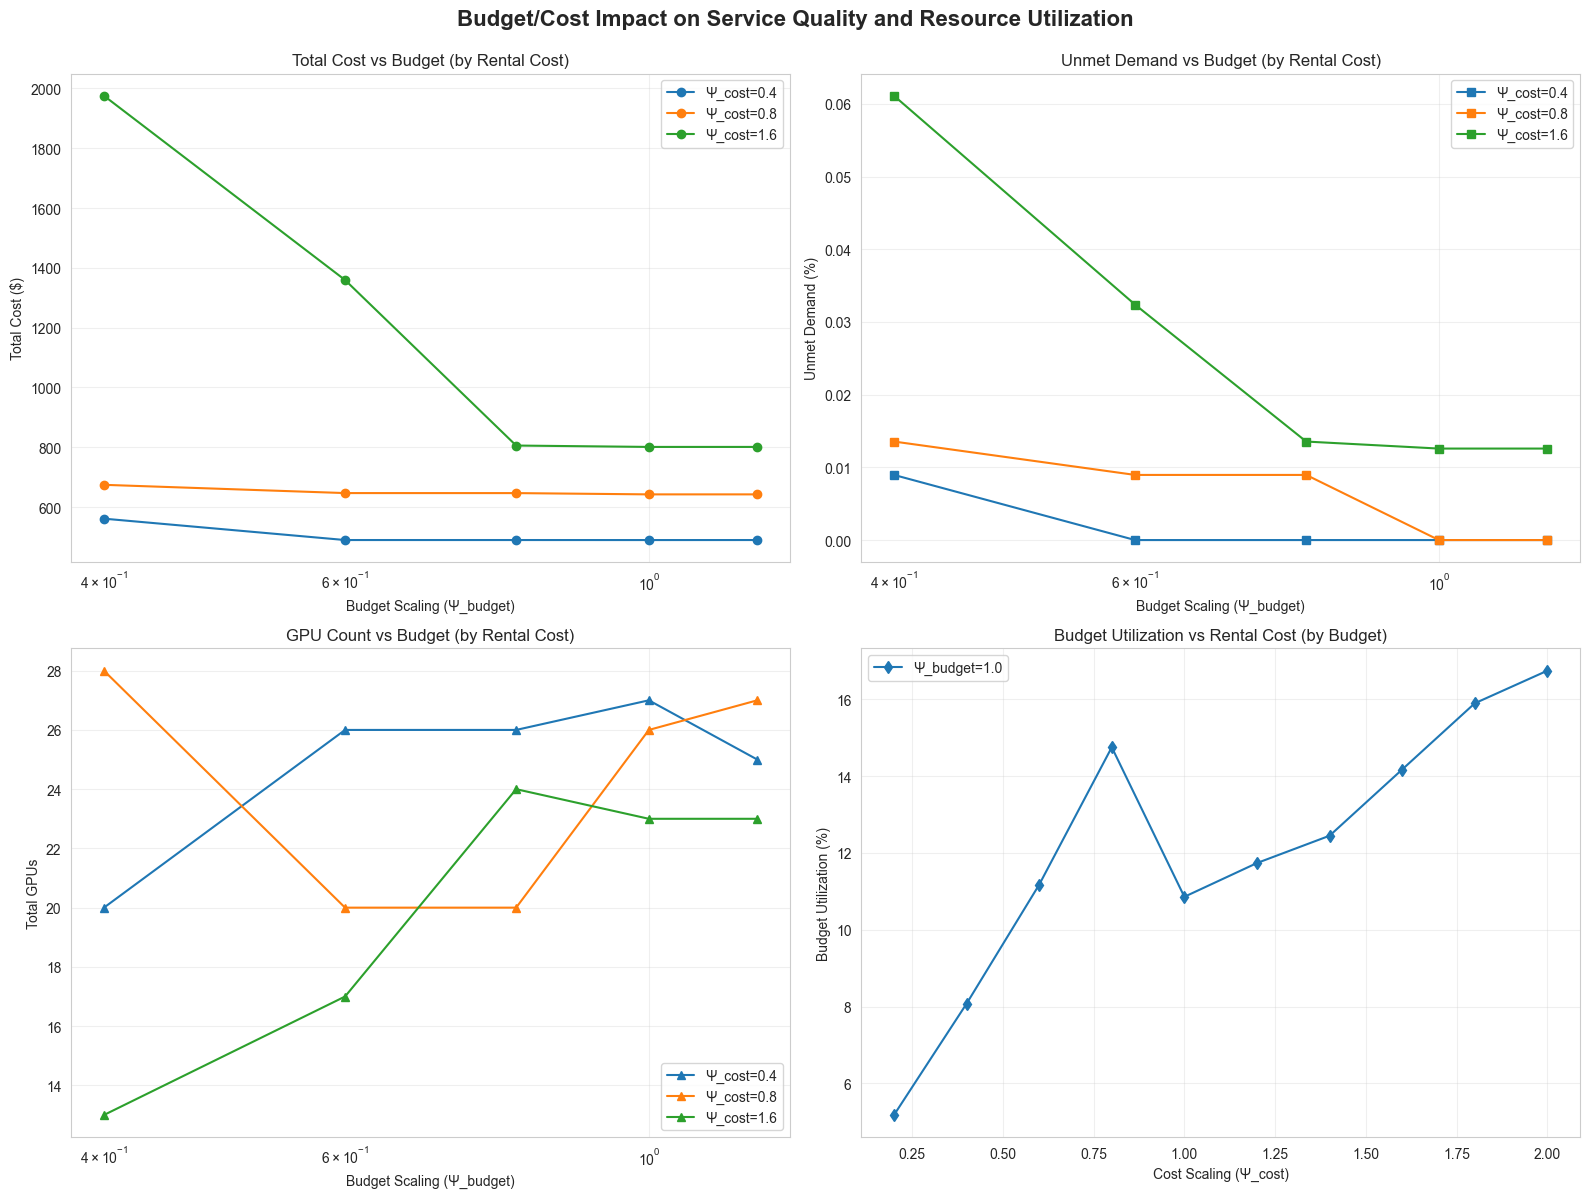

In [ ]:
# Additional Visualizations: Budget/Cost Trade-off Trends

if len(plot_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Budget/Cost Impact on Service Quality and Resource Utilization',
                 fontsize=16, fontweight='bold', y=0.995)
    
    # 1. Total Cost vs Budget for different cost levels
    for psi_c in [0.4, 0.8, 1.6, 2.4, 3.0]:
        subset = plot_df[plot_df['psi_cost'] == psi_c]
        if len(subset) > 0:
            axes[0, 0].plot(subset['psi_budget'], subset['total_cost'],
                           marker='o', label=f'Ψ_cost={psi_c}')
    axes[0, 0].set_title('Total Cost vs Budget (by Rental Cost)')
    axes[0, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 0].set_ylabel('Total Cost ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xscale('log')
    
    # 2. Unmet Demand vs Budget for different cost levels
    for psi_c in [0.4, 0.8, 1.6, 2.4, 3.0]:
        subset = plot_df[plot_df['psi_cost'] == psi_c]
        if len(subset) > 0:
            axes[0, 1].plot(subset['psi_budget'], subset['unmet_demand_pct'],
                           marker='s', label=f'Ψ_cost={psi_c}')
    axes[0, 1].set_title('Unmet Demand vs Budget (by Rental Cost)')
    axes[0, 1].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[0, 1].set_ylabel('Unmet Demand (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xscale('log')
    
    # 3. GPU Count vs Budget for different cost levels
    for psi_c in [0.4, 0.8, 1.6, 2.4, 3.0]:
        subset = plot_df[plot_df['psi_cost'] == psi_c]
        if len(subset) > 0:
            axes[1, 0].plot(subset['psi_budget'], subset['total_gpus'],
                           marker='^', label=f'Ψ_cost={psi_c}')
    axes[1, 0].set_title('GPU Count vs Budget (by Rental Cost)')
    axes[1, 0].set_xlabel('Budget Scaling (Ψ_budget)')
    axes[1, 0].set_ylabel('Total GPUs')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xscale('log')
    
    # 4. Budget Utilization vs Cost for different budget levels
    for psi_b in [0.01, 0.05, 0.1, 0.5, 1.0]:
        subset = plot_df[plot_df['psi_budget'] == psi_b]
        if len(subset) > 0:
            axes[1, 1].plot(subset['psi_cost'], subset['budget_utilization_pct'],
                           marker='d', label=f'Ψ_budget={psi_b}')
    axes[1, 1].set_title('Budget Utilization vs Rental Cost (by Budget)')
    axes[1, 1].set_xlabel('Cost Scaling (Ψ_cost)')
    axes[1, 1].set_ylabel('Budget Utilization (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    figure_filename = os.path.join(output_dir, f'budget_cost_trends_{timestamp}.png')
    plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
    print(f"Trend plots saved to: {figure_filename}")
    plt.show()
    
else:
    print("No successful results to plot!")

# Sensitivity anlysis on impact factor

In [ ]:
from parameter_setup import ParameterGenerator, RobustLLMInferenceData
from RDDU_LLM_inference_opt import LLMInferenceOptimizer


# Generate the base data using ParameterGenerator from parameter_setup
generator = ParameterGenerator(seed=42)

# Generate all parameters
I, J, K, N, TP_degrees = generator.get_problem_dimensions()
query_types = generator.get_query_types()
model_names = generator.get_model_names()
gpu_tiers = generator.get_gpu_tiers()
B = generator.get_model_sizes()
h = generator.get_input_token_lengths()
f = generator.get_output_token_lengths()
C_gpu = generator.get_gpu_memory_capacities()
P_gpu = generator.get_gpu_compute_powers()
beta = generator.get_kv_cache_consumption()
delta, Delta_T, Delta_i, epsilon, C_storage = generator.get_thresholds()

# Generate random parameters
lambda_i = generator.generate_arrival_rates()
p_c = generator.generate_gpu_costs()
p_s = generator.generate_storage_cost()
alpha = generator.generate_compute_consumption()
theta = generator.generate_token_sizes()
rho = generator.generate_delay_penalties()
phi = generator.generate_unmet_penalties()

# Generate performance matrices
d = generator.generate_processing_delays()
e = generator.generate_error_rates()
d_bar, d_hat = generator.generate_uncertainty_delays(d)
e_bar, e_hat = generator.generate_uncertainty_error_rates(e)
Gamma_d, Gamma_e = generator.generate_uncertainty_budgets(I, J)
gamma_impact = generator.generate_gamma_impact(J, K, model_names, P_gpu)
error_impact = generator.generate_error_impact(J, K, model_names, gpu_tiers, P_gpu)
T_res = generator.generate_residency_times(I, J, K)
BigM = generator.get_bigm_value()

# Create data object
base_data = RobustLLMInferenceData(
    I=I, J=J, K=K, N=N, TP_degrees=TP_degrees, BigM=BigM,
    query_types=query_types, model_names=model_names, gpu_tiers=gpu_tiers,
    B=B, h=h, f=f, lambda_i=lambda_i,
    C_gpu=C_gpu, P_gpu=P_gpu, p_c=p_c,
    C_storage=C_storage, p_s=p_s,
    beta=beta, alpha=alpha, theta=theta,
    rho=rho, phi=phi,
    delta=delta, Delta_T=Delta_T,
    Delta_i=Delta_i, epsilon=epsilon,
    d_bar=d_bar, d_hat=d_hat, e_bar=e_bar, e_hat=e_hat,
    Gamma_d=Gamma_d, Gamma_e=Gamma_e,
    gamma_impact=gamma_impact, error_impact=error_impact, T_res=T_res
)


In [ ]:
# ============================================================================
# 2D SENSITIVITY ANALYSIS: Impact Factor Spacing for Gamma and Error
# ============================================================================
# This analysis tests how the spacing between impact factor categories
# affects the optimization results for BOTH delay and error impact factors.
#
# Fixed: Low impact range = (0.05, 0.1) for both gamma and error
# Variable: Delta_impact_gamma ∈ [0.1, 0.15, 0.2, 0.25, 0.3]
#           Delta_impact_error ∈ [0.1, 0.15, 0.2, 0.25, 0.3]
# Total scenarios: 5 x 5 = 25
# ============================================================================

import numpy as np
import pandas as pd
from typing import Dict, Any
import importlib

# Reload modules to get latest changes
import parameter_setup
import RDDU_LLM_inference_opt
importlib.reload(parameter_setup)
importlib.reload(RDDU_LLM_inference_opt)

from parameter_setup import ParameterGenerator, LLMInferenceData
from RDDU_LLM_inference_opt import LLMInferenceOptimizer, LLMInferenceData as RDDUData

def generate_custom_impact_ranges(delta_impact: float) -> Dict[str, tuple]:
    """
    Generate impact ranges based on delta_impact spacing.
    
    Args:
        delta_impact: Spacing between adjacent category centers
    
    Returns:
        Dictionary of impact ranges for each category
    """
    low_center = 0.075  # Fixed: (0.05, 0.1)
    range_width = 0.05  # Width of each range
    half_width = range_width / 2
    
    impact_ranges = {
        'low': (0.05, 0.1),
        'medium': (low_center + delta_impact - half_width, 
                   low_center + delta_impact + half_width),
        'high': (low_center + 2*delta_impact - half_width, 
                 low_center + 2*delta_impact + half_width),
        'luxury': (low_center + 3*delta_impact - half_width, 
                   low_center + 3*delta_impact + half_width)
    }
    
    return impact_ranges

def generate_custom_gamma_impact(J: int, K: int, model_names: list, 
                                  P_gpu: np.ndarray, impact_ranges: Dict) -> np.ndarray:
    """Generate gamma impact with custom ranges (same logic as in parameter_setup)"""
    model_complexity = {
        'Llama-3.2-1B': 'low',
        'Llama-3.2-3B': 'low',
        'Llama-3.1-8B': 'medium',
        'Llama-3.2-11B-Vision': 'medium',
        'Llama-3.1-70B': 'high',
        'Llama-3.2-31B': 'high'
    }
    
    def classify_gpu_power(compute_power):
        if compute_power < 150:
            return 'low'
        elif compute_power < 400:
            return 'medium'
        elif compute_power < 900:
            return 'high'
        else:
            return 'luxury'
    
    gamma_impact = np.zeros((J, K))
    
    for j, model in enumerate(model_names):
        for k in range(K):
            m_complexity = model_complexity[model]
            gpu_power = classify_gpu_power(P_gpu[k])
            
            complexity_level = ['low', 'medium', 'high', 'luxury'].index(m_complexity)
            power_level = ['low', 'medium', 'high', 'luxury'].index(gpu_power)
            
            impact_score = complexity_level - power_level
            
            if impact_score <= -2:
                level_name = 'low'
            elif impact_score == -1:
                level_name = 'low'
            elif impact_score == 0:
                level_name = 'medium'
            elif impact_score == 1:
                level_name = 'high'
            else:
                level_name = 'luxury'
            
            min_impact, max_impact = impact_ranges[level_name]
            gamma_impact[j, k] = np.random.uniform(min_impact, max_impact)
    
    return gamma_impact

def generate_custom_error_impact(J: int, K: int, model_names: list,
                                  gpu_tiers: list, P_gpu: np.ndarray, 
                                  impact_ranges: Dict) -> np.ndarray:
    """Generate error impact with custom ranges (same logic as in parameter_setup)"""
    model_quality = {
        'Llama-3.2-1B': 'low',
        'Llama-3.2-3B': 'low',
        'Llama-3.1-8B': 'medium',
        'Llama-3.2-11B-Vision': 'medium',
        'Llama-3.1-70B': 'high',
        'Llama-3.2-31B': 'high'
    }
    
    def classify_gpu_precision(gpu_name, compute_power):
        if 'INT4' in gpu_name:
            precision_penalty = -1
        elif 'INT8' in gpu_name:
            precision_penalty = 0
        elif 'FP16' in gpu_name or 'BF16' in gpu_name:
            precision_penalty = 1
        else:
            precision_penalty = 1
        
        if compute_power < 150:
            base_level = 0
        elif compute_power < 400:
            base_level = 1
        elif compute_power < 900:
            base_level = 2
        else:
            base_level = 3
        
        final_level = max(0, min(3, base_level + precision_penalty))
        return ['low', 'medium', 'high', 'luxury'][final_level]
    
    error_impact = np.zeros((J, K))
    
    for j, model in enumerate(model_names):
        for k, gpu_name in enumerate(gpu_tiers):
            m_quality = model_quality[model]
            gpu_precision = classify_gpu_precision(gpu_name, P_gpu[k])
            
            quality_level = ['low', 'medium', 'high', 'luxury'].index(m_quality)
            precision_level = ['low', 'medium', 'high', 'luxury'].index(gpu_precision)
            
            weighted_score = (2 * quality_level + precision_level) / 3.0
            
            if weighted_score < 0.75:
                level_name = 'low'
            elif weighted_score < 1.5:
                level_name = 'medium'
            elif weighted_score < 2.25:
                level_name = 'high'
            else:
                level_name = 'luxury'
            
            min_impact, max_impact = impact_ranges[level_name]
            error_impact[j, k] = np.random.uniform(min_impact, max_impact)
    
    return error_impact

def run_2d_delta_impact_analysis(delta_gamma: float, delta_error: float, base_data,
                                   time_limit: int = 300, mip_gap: float = 0.01) -> Dict[str, Any]:
    """Run optimization with specified delta_impact values for gamma and error"""
    
    # Generate custom impact ranges (separate for gamma and error)
    gamma_ranges = generate_custom_impact_ranges(delta_gamma)
    error_ranges = generate_custom_impact_ranges(delta_error)
    
    # Generate custom impact factors
    gamma_impact = generate_custom_gamma_impact(
        base_data.J, base_data.K, base_data.model_names, base_data.P_gpu, gamma_ranges
    )
    error_impact = generate_custom_error_impact(
        base_data.J, base_data.K, base_data.model_names, base_data.gpu_tiers, 
        base_data.P_gpu, error_ranges
    )
    
    # Handle d and e attributes (may not exist in RobustLLMInferenceData)
    d_val = base_data.d if hasattr(base_data, 'd') else base_data.d_bar
    e_val = base_data.e if hasattr(base_data, 'e') else base_data.e_bar
    
    # Create modified data with custom impacts
    modified_data = RDDUData(
        I=base_data.I, J=base_data.J, K=base_data.K, N=base_data.N,
        query_types=base_data.query_types, model_names=base_data.model_names,
        gpu_tiers=base_data.gpu_tiers, B=base_data.B, TP_degrees=base_data.TP_degrees,
        h=base_data.h, f=base_data.f, lambda_i=base_data.lambda_i,
        C_gpu=base_data.C_gpu, P_gpu=base_data.P_gpu, p_c=base_data.p_c,
        C_storage=base_data.C_storage, p_s=base_data.p_s, beta=base_data.beta,
        alpha=base_data.alpha, theta=base_data.theta, rho=base_data.rho,
        phi=base_data.phi, delta=base_data.delta, Delta_T=base_data.Delta_T,
        Delta_i=base_data.Delta_i, epsilon=base_data.epsilon,
        d=d_val, e=e_val,
        d_bar=base_data.d_bar, d_hat=base_data.d_hat,
        e_bar=base_data.e_bar, e_hat=base_data.e_hat,
        Gamma_d=base_data.Gamma_d, Gamma_e=base_data.Gamma_e,
        gamma_impact=gamma_impact, error_impact=error_impact,
        T_res=base_data.T_res, BigM=base_data.BigM
    )
    
    # Solve optimization
    try:
        optimizer = LLMInferenceOptimizer(modified_data)
        solution = optimizer.build_and_solve_optimization_problem(time_limit=time_limit,
                                                                   mip_gap=mip_gap)
        
        if solution is None:
            return {
                'delta_gamma': delta_gamma,
                'delta_error': delta_error,
                'status': 'INFEASIBLE',
                'total_cost': np.nan,
                'gpu_rental_cost': np.nan,
                'total_gpus': np.nan,
                'delay_penalty': np.nan,
                'budget_utilization_pct': np.nan,
                'unmet_demand_pct': np.nan,
                'gamma_impact_min': np.nan,
                'gamma_impact_max': np.nan,
                'error_impact_min': np.nan,
                'error_impact_max': np.nan,
                'solve_time': 0
            }
        
        # Calculate metrics from solution
        total_cost = solution['objective']
        
        # GPU rental cost
        gpu_rental_cost = sum(modified_data.Delta_T * modified_data.p_c[k] * y_val 
                              for (j, k), y_val in solution['y'].items())
        
        # Total GPUs
        total_gpus = sum(solution['y'].values())
        
        # Delay penalty from optimizer vars
        delay_penalty = optimizer.vars['varrho'].X if hasattr(optimizer.vars['varrho'], 'X') else 0
        
        # Calculate demand metrics
        total_demand = sum(modified_data.lambda_i)
        served_demand = sum(modified_data.lambda_i[i] * (1 - sum(u_val for (ii, k), u_val in solution['u'].items() if ii == i))
                           for i in range(modified_data.I))
        unmet_demand = total_demand - served_demand
        
        budget_utilization = (gpu_rental_cost / modified_data.delta) * 100
        unmet_demand_pct = (unmet_demand / total_demand) * 100 if total_demand > 0 else 0
        
        return {
            'delta_gamma': delta_gamma,
            'delta_error': delta_error,
            'status': solution['status'],
            'total_cost': total_cost,
            'gpu_rental_cost': gpu_rental_cost,
            'total_gpus': total_gpus,
            'delay_penalty': delay_penalty,
            'budget_utilization_pct': budget_utilization,
            'unmet_demand_pct': unmet_demand_pct,
            'gamma_impact_min': gamma_impact.min(),
            'gamma_impact_max': gamma_impact.max(),
            'error_impact_min': error_impact.min(),
            'error_impact_max': error_impact.max(),
            'solve_time': 0
        }
        
    except Exception as e:
        return {
            'delta_gamma': delta_gamma,
            'delta_error': delta_error,
            'status': 'ERROR',
            'error_message': str(e),
            'total_cost': np.nan,
            'gpu_rental_cost': np.nan,
            'total_gpus': np.nan,
            'delay_penalty': np.nan,
            'budget_utilization_pct': np.nan,
            'unmet_demand_pct': np.nan,
            'gamma_impact_min': np.nan,
            'gamma_impact_max': np.nan,
            'error_impact_min': np.nan,
            'error_impact_max': np.nan,
            'solve_time': 0
        }

delta_values = [0.1, 0.15, 0.2, 0.25, 0.3]

print("="*80)
print("2D DELTA_IMPACT SENSITIVITY ANALYSIS SETUP")
print("="*80)
print(f"Fixed low impact range: (0.05, 0.1) for both gamma and error")
print(f"Delta values: {delta_values}")
print(f"Total scenarios: {len(delta_values)} x {len(delta_values)} = {len(delta_values)**2}")

# Storage for results
delta_2d_results = []

print("\n" + "="*80)
print("Starting 2D Delta_impact sensitivity analysis...")
print("="*80)

counter = 0

for delta_gamma in delta_values:
    for delta_error in delta_values:
        counter += 1
        print(f"\n[{counter}/{total}] Delta_gamma={delta_gamma:.2f}, Delta_error={delta_error:.2f}")
        
        result = run_2d_delta_impact_analysis(delta_gamma, delta_error, base_data, time_limit=300, mip_gap=0.01)
        delta_2d_results.append(result)
        
        if result['status'] in ['OPTIMAL', 'TIME_LIMIT']:
            print(f"  ✓ Status: {result['status']}")
            print(f"    Total Cost: ${result['total_cost']:.2f}")
            print(f"    GPU Rental: ${result['gpu_rental_cost']:.2f}")
            print(f"    Total GPUs: {result['total_gpus']:.0f}")
            print(f"    Delay Penalty: ${result['delay_penalty']:.2f}")
            print(f"    Budget Util: {result['budget_utilization_pct']:.1f}%")
            print(f"    Unmet Demand: {result['unmet_demand_pct']:.1f}%")
            print(f"    Gamma: [{result['gamma_impact_min']:.3f}, {result['gamma_impact_max']:.3f}]")
            print(f"    Error: [{result['error_impact_min']:.3f}, {result['error_impact_max']:.3f}]")
        else:
            print(f"  ✗ Status: {result['status']}")
            if 'error_message' in result:
                print(f"    Error: {result['error_message']}")

print("\n" + "="*80)
print("2D Delta_impact sensitivity analysis completed!")
print("="*80)

# Convert to DataFrame
delta_2d_df = pd.DataFrame(delta_2d_results)

# Display summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
successful = delta_2d_df[delta_2d_df['status'].isin(['OPTIMAL', 'TIME_LIMIT'])]
print(f"Total scenarios: {len(delta_2d_df)}")
print(f"Successful: {len(successful)}")
print(f"Errors: {sum(delta_2d_df['status'] == 'ERROR')}")

if len(successful) > 0:
    print(f"\nCost Statistics:")
    print(f"  Min: ${successful['total_cost'].min():.2f}")
    print(f"  Max: ${successful['total_cost'].max():.2f}")
    print(f"  Range: ${successful['total_cost'].max() - successful['total_cost'].min():.2f}")
    print(f"  Mean: ${successful['total_cost'].mean():.2f}")
    print(f"  Std Dev: ${successful['total_cost'].std():.2f}")
    
    print(f"\nBudget Utilization:")
    print(f"  Min: {successful['budget_utilization_pct'].min():.1f}%")
    print(f"  Max: {successful['budget_utilization_pct'].max():.1f}%")
    print(f"  Mean: {successful['budget_utilization_pct'].mean():.1f}%")
    
    print(f"\nUnmet Demand:")
    print(f"  Min: {successful['unmet_demand_pct'].min():.1f}%")
    print(f"  Max: {successful['unmet_demand_pct'].max():.1f}%")
    print(f"  Mean: {successful['unmet_demand_pct'].mean():.1f}%")

# Display detailed results table
print("\n" + "="*80)
print("DETAILED RESULTS TABLE")
print("="*80)

display_df = delta_2d_df[['delta_gamma', 'delta_error', 'status', 'total_cost', 
                           'gpu_rental_cost', 'total_gpus', 'delay_penalty', 
                           'budget_utilization_pct', 'unmet_demand_pct']].copy()
print(display_df.to_string(index=False))

# Create pivot table for visualization
print("\n" + "="*80)
print("PIVOT TABLE: Total Cost by Delta_gamma x Delta_error")
print("="*80)

if len(successful) > 0:
    pivot_cost = successful.pivot_table(
        values='total_cost', 
        index='delta_gamma', 
        columns='delta_error',
        aggfunc='mean'
    )
    print(pivot_cost.to_string(float_format=lambda x: f'${x:.2f}'))
    
    print("\n" + "="*80)
    print("PIVOT TABLE: Budget Utilization (%) by Delta_gamma x Delta_error")
    print("="*80)
    
    pivot_budget = successful.pivot_table(
        values='budget_utilization_pct', 
        index='delta_gamma', 
        columns='delta_error',
        aggfunc='mean'
    )
    print(pivot_budget.to_string(float_format=lambda x: f'{x:.1f}%'))
    
    print("\n" + "="*80)
    print("PIVOT TABLE: Unmet Demand (%) by Delta_gamma x Delta_error")
    print("="*80)
    
    pivot_unmet = successful.pivot_table(
        values='unmet_demand_pct', 
        index='delta_gamma', 
        columns='delta_error',
        aggfunc='mean'
    )
    print(pivot_unmet.to_string(float_format=lambda x: f'{x:.1f}%'))


2D DELTA_IMPACT SENSITIVITY ANALYSIS SETUP
Fixed low impact range: (0.05, 0.1) for both gamma and error
Delta values: [0.1, 0.15, 0.2, 0.25, 0.3]
Total scenarios: 5 x 5 = 25

Starting 2D Delta_impact sensitivity analysis...

[1/25] Delta_gamma=0.10, Delta_error=0.10
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ Status: OPTIMAL
    Total Cost: $888.13
    GPU Rental: $307.30
    Total GPUs: 23
    Delay Penalty: $535.63
    Budget Util: 6.1%
    Unmet Demand: 0.0%
    Gamma: [0.051, 0.399]
    Error: [0.052, 0.384]

[2/25] Delta_gamma=0.10, Delta_error=0.15
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ Status: OPTIMAL
    Total Cost: $875.77
    GPU Rental: $307.30
    Total GPUs: 23
    Delay Penalty: $523.27
    Budget Util: 6.1%
    Unmet Demand: 0.0%
    Gamma: [0.052, 0.398]
    Error: [0.053, 0.537]

[3/25] Delta_gamma=0.10, Delta_error=0.20
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ Statu

In [ ]:

# ============================================================================
# SAVE RESULTS TO CSV
# ============================================================================

import os
from datetime import datetime

# Create sensitivity_analysis directory if it doesn't exist
output_dir = "sensitivity_analysis"
os.makedirs(output_dir, exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"delta_impact_2d_sensitivity_{timestamp}.csv"
filepath = os.path.join(output_dir, filename)

# Save to CSV
delta_2d_df.to_csv(filepath, index=False)

print("\n" + "="*80)
print("RESULTS SAVED")
print("="*80)
print(f"File saved to: {filepath}")
print(f"Total rows: {len(delta_2d_df)}")
print(f"Columns: {list(delta_2d_df.columns)}")



RESULTS SAVED
File saved to: sensitivity_analysis/delta_impact_2d_sensitivity_20251023_165132.csv
Total rows: 25
Columns: ['delta_gamma', 'delta_error', 'status', 'total_cost', 'gpu_rental_cost', 'total_gpus', 'delay_penalty', 'budget_utilization_pct', 'unmet_demand_pct', 'gamma_impact_min', 'gamma_impact_max', 'error_impact_min', 'error_impact_max', 'solve_time']


2D SENSITIVITY ANALYSIS: Delay Threshold Scaling vs Delay Impact Spacing

Base configuration:
  Query types (I): 6
  Models (J): 6
  GPU tiers (K): 10
  Base Delta_i (delay thresholds): [1000 1500  800 2000 4000 5000]
  Base epsilon: [0.04 0.08 0.03 0.1  0.12 0.2 ]

Parameter ranges:
  Delta_error (FIXED): 0.2
  Epsilon_scale (FIXED): 1.0
  Delta_gamma (VARIABLE): [0.1, 0.15, 0.2, 0.25, 0.3]
  Delta_i_scale (VARIABLE): [0.1, 0.3, 0.5, 0.7, 0.9]
  Total scenarios: 25

[1/25] Δ_gamma=0.10, Δ_i_scale=0.10
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ OPTIMAL: $1,038.95 (gap: 0.0084)

[2/25] Δ_gamma=0.10, Δ_i_scale=0.30
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ OPTIMAL: $930.89 (gap: 0.0100)

[3/25] Δ_gamma=0.10, Δ_i_scale=0.50
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ OPTIMAL: $894.16 (gap: 0.0010)

[4/25] Δ_gamma=0.10, Δ_i_scale=0.70
Set parameter MIPGap to value 0.01
Set parameter TimeLimit

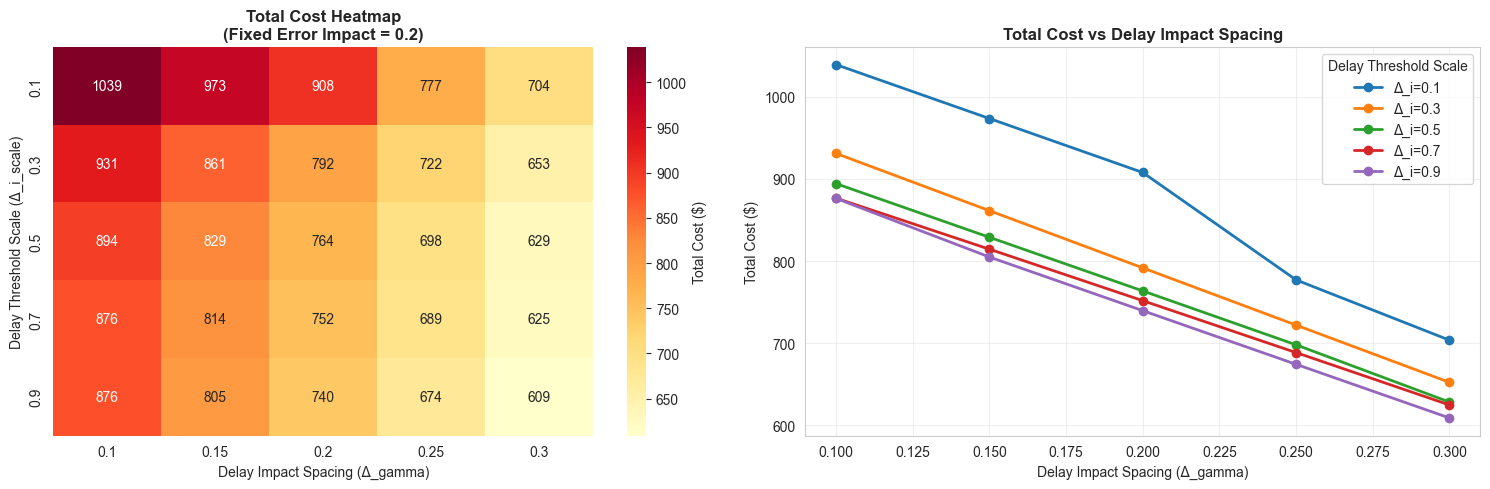

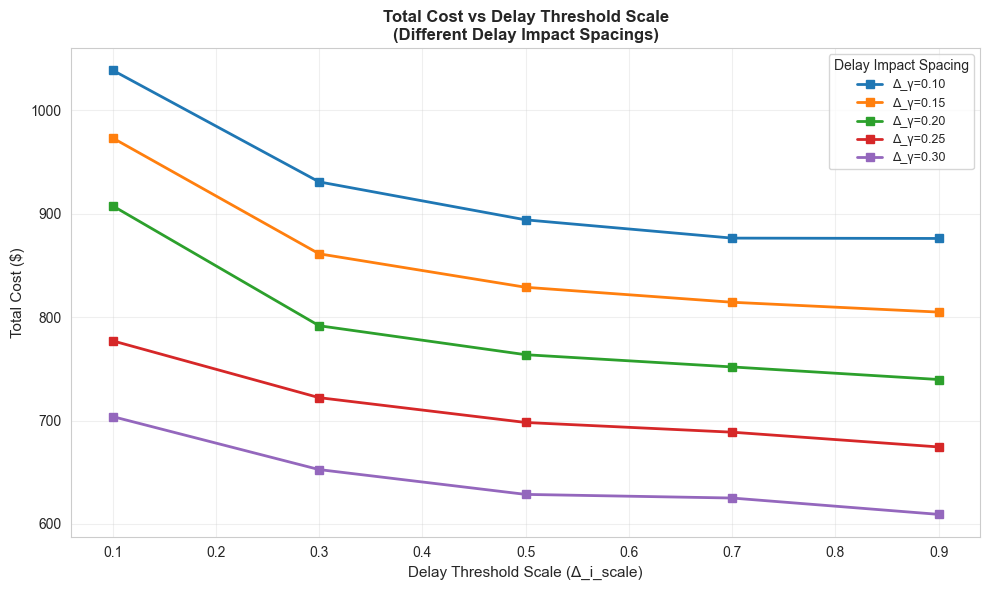


SUMMARY STATISTICS:
  Cost range: $609.22 - $1,038.95
  Cost mean: $785.36
  Cost std: $114.70

Best scenario (lowest cost):
  Δ_gamma = 0.30
  Δ_i_scale = 0.90
  Total cost = $609.22

Worst scenario (highest cost):
  Δ_gamma = 0.10
  Δ_i_scale = 0.10
  Total cost = $1,038.95

Parameter Effects:
  Effect of Delay Impact Spacing (Δ_gamma):
    Δ_gamma=0.10: Avg cost = $923.33
    Δ_gamma=0.15: Avg cost = $856.60
    Δ_gamma=0.20: Avg cost = $790.94
    Δ_gamma=0.25: Avg cost = $712.11
    Δ_gamma=0.30: Avg cost = $643.84

  Effect of Delay Threshold Scale (Δ_i_scale):
    Δ_i_scale=0.1: Avg cost = $880.22
    Δ_i_scale=0.3: Avg cost = $791.72
    Δ_i_scale=0.5: Avg cost = $762.69
    Δ_i_scale=0.7: Avg cost = $751.30
    Δ_i_scale=0.9: Avg cost = $740.88

Results saved to 'delay_sensitivity_results.csv'


In [ ]:
# ============================================================================
# 2D SENSITIVITY ANALYSIS: Delay Threshold Scaling vs Delay Impact Spacing
# ============================================================================
# This analysis tests how delay-related parameters affect total cost
# while keeping error impact factors FIXED.
#
# Fixed: Delta_impact_error = 0.2 (error impact spacing)
#        Epsilon_scale = 1.0 (error threshold at baseline)
# Variable: Delta_impact_gamma ∈ [0.1, 0.15, 0.2, 0.25, 0.3]
#           Delta_i_scale ∈ [0.1, 0.3, 0.5, 0.7, 0.9] (delay threshold scaling)
# Total scenarios: 5 x 5 = 25
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
import importlib
import copy

# Reload modules
import RDDU_LLM_inference_opt
importlib.reload(RDDU_LLM_inference_opt)

from RDDU_LLM_inference_opt import DataGenerator, LLMInferenceOptimizer, LLMInferenceData as RDDUData

def generate_custom_impact_ranges(delta_impact: float) -> Dict[str, tuple]:
    """
    Generate impact ranges by adding increments to base range.

    Args:
        delta_impact: Increment to add for each category level

    Returns:
        Dictionary of impact ranges for each category
    """
    # Base range (low category)
    base_low = 0.05
    base_high = 0.1

    impact_ranges = {
        'low':    (base_low,                base_high),
        'medium': (base_low + delta_impact, base_high + delta_impact),
        'high':   (base_low + 2*delta_impact, base_high + 2*delta_impact),
        'luxury': (base_low + 3*delta_impact, base_high + 3*delta_impact)
    }

    return impact_ranges

def generate_custom_gamma_impact(J: int, K: int, delta_impact: float, seed: int = 42) -> np.ndarray:
    """Generate delay impact factors with custom spacing (J x K matrix)."""
    np.random.seed(seed)
    gamma_impact = np.zeros((J, K))
    impact_ranges = generate_custom_impact_ranges(delta_impact)

    # Model assignments (matching original generator)
    assignments = {0: 'luxury', 1: 'high', 2: 'high', 3: 'medium', 4: 'low', 5: 'low'}

    for j in range(J):
        low, high = impact_ranges[assignments[j]]
        # Same value for all K GPU tiers for this model
        gamma_impact[j, :] = np.random.uniform(low, high)

    return gamma_impact

def generate_custom_error_impact(J: int, K: int, delta_impact: float, seed: int = 43) -> np.ndarray:
    """Generate error impact factors with custom spacing (J x K matrix)."""
    np.random.seed(seed)
    error_impact = np.zeros((J, K))
    impact_ranges = generate_custom_impact_ranges(delta_impact)

    # Model assignments (matching original generator)
    assignments = {0: 'low', 1: 'low', 2: 'low', 3: 'medium', 4: 'high', 5: 'luxury'}

    for j in range(J):
        low, high = impact_ranges[assignments[j]]
        # Same value for all K GPU tiers for this model
        error_impact[j, :] = np.random.uniform(low, high)

    return error_impact

# Generate base parameters
print("="*80)
print("2D SENSITIVITY ANALYSIS: Delay Threshold Scaling vs Delay Impact Spacing")
print("="*80)

# Use DataGenerator from RDDU_LLM_inference_opt
data_gen = DataGenerator(seed=42)
base_data = data_gen.generate()

print(f"\nBase configuration:")
print(f"  Query types (I): {base_data.I}")
print(f"  Models (J): {base_data.J}")
print(f"  GPU tiers (K): {base_data.K}")
print(f"  Base Delta_i (delay thresholds): {base_data.Delta_i}")
print(f"  Base epsilon: {base_data.epsilon}")

# Parameter ranges
DELTA_ERROR_FIXED = 0.2      # Fixed error impact spacing
EPSILON_SCALE_FIXED = 1.0    # Fixed error threshold scale (baseline)
delta_gamma_values = [0.1, 0.15, 0.2, 0.25, 0.3]
delta_i_scale_values = [0.1, 0.3, 0.5, 0.7, 0.9]

print(f"\nParameter ranges:")
print(f"  Delta_error (FIXED): {DELTA_ERROR_FIXED}")
print(f"  Epsilon_scale (FIXED): {EPSILON_SCALE_FIXED}")
print(f"  Delta_gamma (VARIABLE): {delta_gamma_values}")
print(f"  Delta_i_scale (VARIABLE): {delta_i_scale_values}")
print(f"  Total scenarios: {len(delta_gamma_values) * len(delta_i_scale_values)}")

# Run analysis
results_delay_sens = []
counter = 0
total = len(delta_gamma_values) * len(delta_i_scale_values)

for delta_gamma in delta_gamma_values:
    for delta_i_scale in delta_i_scale_values:
        counter += 1
        print(f"\n[{counter}/{total}] Δ_gamma={delta_gamma:.2f}, Δ_i_scale={delta_i_scale:.2f}")

        # Create a copy of base data
        modified_data = copy.deepcopy(base_data)

        # Generate and update custom impact factors
        modified_data.gamma_impact = generate_custom_gamma_impact(base_data.J, base_data.K, delta_gamma)
        modified_data.error_impact = generate_custom_error_impact(base_data.J, base_data.K, DELTA_ERROR_FIXED)

        # Scale delay thresholds (Delta_i)
        modified_data.Delta_i = base_data.Delta_i * delta_i_scale

        # Keep error thresholds at baseline
        modified_data.epsilon = base_data.epsilon * EPSILON_SCALE_FIXED

        # Solve
        try:
            optimizer = LLMInferenceOptimizer(modified_data)
            solution = optimizer.build_and_solve_optimization_problem(
                time_limit=300, mip_gap=0.01
            )

            if solution is not None and solution['status'] in ['OPTIMAL', 'TIME_LIMIT']:
                results_delay_sens.append({
                    'delta_gamma': delta_gamma,
                    'delta_error': DELTA_ERROR_FIXED,
                    'delta_i_scale': delta_i_scale,
                    'epsilon_scale': EPSILON_SCALE_FIXED,
                    'status': solution['status'],
                    'total_cost': solution['objective'],
                    'gap': solution.get('gap'),
                    'num_allocations': len(solution.get('x', {})),
                    'num_gpus': len(solution.get('y', {})),
                    'unmet_demand': len(solution.get('u', {}))
                })
                print(f"  ✓ {solution['status']}: ${solution['objective']:,.2f} (gap: {solution.get('gap', 0):.4f})")
            else:
                print(f"  ✗ FAILED")
        except Exception as e:
            print(f"  ✗ ERROR: {str(e)}")

# Convert to DataFrame
df_delay_sens = pd.DataFrame(results_delay_sens)
print(f"\n{'='*80}")
print(f"COMPLETE: {len(df_delay_sens)}/{total} successful scenarios")
print(f"{'='*80}")

# Check if we have results to visualize
if len(df_delay_sens) == 0:
    print("\n⚠️  WARNING: No successful scenarios to visualize!")
    print("All optimization runs failed. Please check:")
    print("  1. Data generation is working correctly")
    print("  2. Optimization model has feasible solutions")
    print("  3. Error messages above for clues")
else:
    # Quick visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Heatmap
    cost_pivot = df_delay_sens.pivot_table(
        values='total_cost',
        index='delta_i_scale',
        columns='delta_gamma'
    )
    sns.heatmap(cost_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0],
                cbar_kws={'label': 'Total Cost ($)'})
    axes[0].set_title('Total Cost Heatmap\n(Fixed Error Impact = 0.2)', fontweight='bold')
    axes[0].set_xlabel('Delay Impact Spacing (Δ_gamma)')
    axes[0].set_ylabel('Delay Threshold Scale (Δ_i_scale)')

    # Line plot
    for delta_i in sorted(df_delay_sens['delta_i_scale'].unique()):
        subset = df_delay_sens[df_delay_sens['delta_i_scale'] == delta_i]
        axes[1].plot(subset['delta_gamma'], subset['total_cost'],
                    marker='o', label=f'Δ_i={delta_i:.1f}', linewidth=2)

    axes[1].set_xlabel('Delay Impact Spacing (Δ_gamma)')
    axes[1].set_ylabel('Total Cost ($)')
    axes[1].set_title('Total Cost vs Delay Impact Spacing', fontweight='bold')
    axes[1].legend(title='Delay Threshold Scale')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional plot: Cost vs delay threshold scale
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))

    for delta_g in sorted(df_delay_sens['delta_gamma'].unique()):
        subset = df_delay_sens[df_delay_sens['delta_gamma'] == delta_g]
        ax2.plot(subset['delta_i_scale'], subset['total_cost'],
                marker='s', label=f'Δ_γ={delta_g:.2f}', linewidth=2)

    ax2.set_xlabel('Delay Threshold Scale (Δ_i_scale)', fontsize=11)
    ax2.set_ylabel('Total Cost ($)', fontsize=11)
    ax2.set_title('Total Cost vs Delay Threshold Scale\n(Different Delay Impact Spacings)',
                  fontsize=12, fontweight='bold')
    ax2.legend(title='Delay Impact Spacing', fontsize=9)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSUMMARY STATISTICS:")
    print(f"  Cost range: ${df_delay_sens['total_cost'].min():,.2f} - ${df_delay_sens['total_cost'].max():,.2f}")
    print(f"  Cost mean: ${df_delay_sens['total_cost'].mean():,.2f}")
    print(f"  Cost std: ${df_delay_sens['total_cost'].std():,.2f}")

    best_idx = df_delay_sens['total_cost'].idxmin()
    print(f"\nBest scenario (lowest cost):")
    print(f"  Δ_gamma = {df_delay_sens.loc[best_idx, 'delta_gamma']:.2f}")
    print(f"  Δ_i_scale = {df_delay_sens.loc[best_idx, 'delta_i_scale']:.2f}")
    print(f"  Total cost = ${df_delay_sens.loc[best_idx, 'total_cost']:,.2f}")

    worst_idx = df_delay_sens['total_cost'].idxmax()
    print(f"\nWorst scenario (highest cost):")
    print(f"  Δ_gamma = {df_delay_sens.loc[worst_idx, 'delta_gamma']:.2f}")
    print(f"  Δ_i_scale = {df_delay_sens.loc[worst_idx, 'delta_i_scale']:.2f}")
    print(f"  Total cost = ${df_delay_sens.loc[worst_idx, 'total_cost']:,.2f}")

    # Analyze parameter effects
    print(f"\nParameter Effects:")
    print(f"  Effect of Delay Impact Spacing (Δ_gamma):")
    for delta_g in sorted(df_delay_sens['delta_gamma'].unique()):
        avg_cost = df_delay_sens[df_delay_sens['delta_gamma'] == delta_g]['total_cost'].mean()
        print(f"    Δ_gamma={delta_g:.2f}: Avg cost = ${avg_cost:,.2f}")

    print(f"\n  Effect of Delay Threshold Scale (Δ_i_scale):")
    for delta_i in sorted(df_delay_sens['delta_i_scale'].unique()):
        avg_cost = df_delay_sens[df_delay_sens['delta_i_scale'] == delta_i]['total_cost'].mean()
        print(f"    Δ_i_scale={delta_i:.1f}: Avg cost = ${avg_cost:,.2f}")

    # Save results
    csv_filename = f'{output_dir}/error_sensitivity_{timestamp}.csv'
    df_delay_sens.to_csv(csv_filename, index=False)
    print(f"\nResults saved to '{csv_filename}'")


In [ ]:
from parameter_setup import ParameterGenerator, RobustLLMInferenceData
from RDDU_LLM_inference_opt import LLMInferenceOptimizer


# Generate the base data using ParameterGenerator from parameter_setup
generator = ParameterGenerator(seed=42)

# Generate all parameters
I, J, K, N, TP_degrees = generator.get_problem_dimensions()
query_types = generator.get_query_types()
model_names = generator.get_model_names()
gpu_tiers = generator.get_gpu_tiers()
B = generator.get_model_sizes()
h = generator.get_input_token_lengths()
f = generator.get_output_token_lengths()
C_gpu = generator.get_gpu_memory_capacities()
P_gpu = generator.get_gpu_compute_powers()
beta = generator.get_kv_cache_consumption()
delta, Delta_T, Delta_i, epsilon, C_storage = generator.get_thresholds()

# Generate random parameters
lambda_i = generator.generate_arrival_rates()
p_c = generator.generate_gpu_costs()
p_s = generator.generate_storage_cost()
alpha = generator.generate_compute_consumption()
theta = generator.generate_token_sizes()
rho = generator.generate_delay_penalties()
phi = generator.generate_unmet_penalties()

# Generate performance matrices
d = generator.generate_processing_delays()
e = generator.generate_error_rates()
d_bar, d_hat = generator.generate_uncertainty_delays(d)
e_bar, e_hat = generator.generate_uncertainty_error_rates(e)
Gamma_d, Gamma_e = generator.generate_uncertainty_budgets(I, J)
gamma_impact = generator.generate_gamma_impact(J, K, model_names, P_gpu)
error_impact = generator.generate_error_impact(J, K, model_names, gpu_tiers, P_gpu)
T_res = generator.generate_residency_times(I, J, K)
BigM = generator.get_bigm_value()

# Create data object
base_data = RobustLLMInferenceData(
    I=I, J=J, K=K, N=N, TP_degrees=TP_degrees, BigM=BigM,
    query_types=query_types, model_names=model_names, gpu_tiers=gpu_tiers,
    B=B, h=h, f=f, lambda_i=lambda_i,
    C_gpu=C_gpu, P_gpu=P_gpu, p_c=p_c,
    C_storage=C_storage, p_s=p_s,
    beta=beta, alpha=alpha, theta=theta,
    rho=rho, phi=phi,
    delta=delta, Delta_T=Delta_T,
    Delta_i=Delta_i*5, epsilon=epsilon,
    d_bar=d_bar, d_hat=d_hat, e_bar=e_bar, e_hat=e_hat,
    Gamma_d=Gamma_d, Gamma_e=Gamma_e,
    gamma_impact=gamma_impact, error_impact=error_impact, T_res=T_res
)


Output directory: sensitivity_analysis/
Timestamp: 20251026_131516
2D SENSITIVITY ANALYSIS: Error Impact Spacing vs Error Rate Threshold

Base configuration:
  Query types (I): 6
  Models (J): 6
  GPU tiers (K): 10
  Base epsilon: [0.04 0.08 0.03 0.1  0.12 0.2 ]

Parameter ranges:
  Delta_gamma (FIXED): 0.3
  Delta_error: [0.1, 0.15, 0.2, 0.25, 0.3]
  Epsilon_scale: [0.4, 0.6]
  Total scenarios: 10

[1/10] Δ_error=0.10, ε_scale=0.40
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ OPTIMAL: $1,060.34 (gap: 0.0000)

[2/10] Δ_error=0.10, ε_scale=0.60
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ OPTIMAL: $804.06 (gap: 0.0064)

[3/10] Δ_error=0.15, ε_scale=0.40
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ OPTIMAL: $1,060.34 (gap: 0.0000)

[4/10] Δ_error=0.15, ε_scale=0.60
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
  ✓ OPTIMAL: $804.03 (gap: 0.0000)

[5/10] Δ_error=0.20, ε_sc

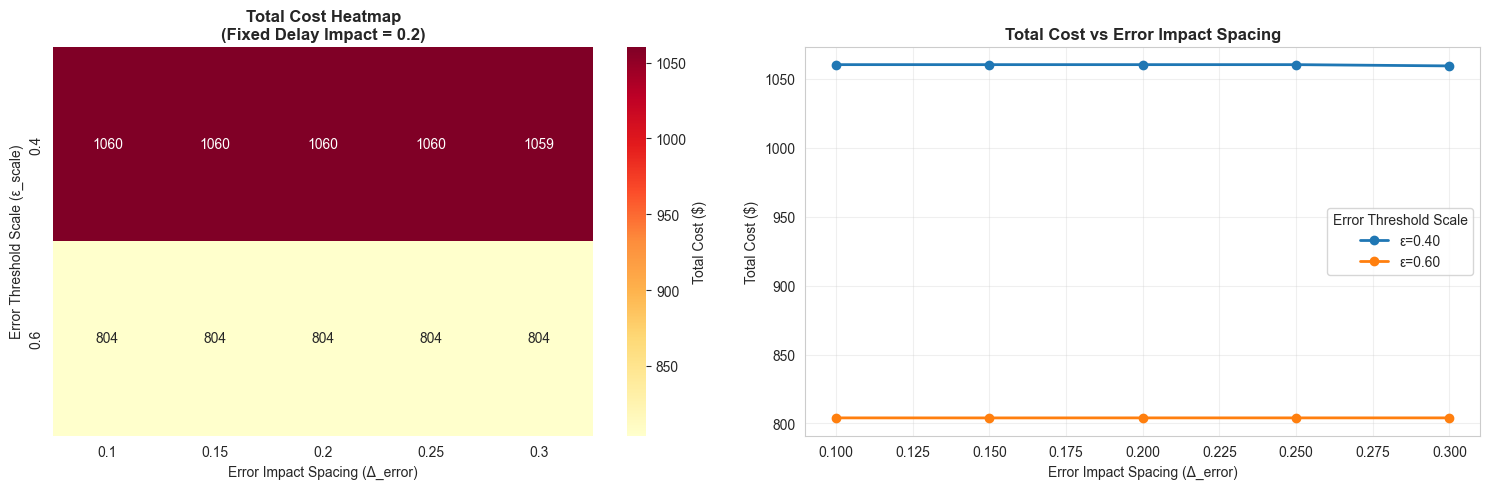


SUMMARY STATISTICS:
  Cost range: $804.03 - $1,060.34
  Cost mean: $932.11
  Cost std: $134.98

Best scenario (lowest cost):
  Δ_error = 0.15
  ε_scale = 0.60
  Total cost = $804.03

Results saved to 'sensitivity_analysis/error_sensitivity_20251026_131516.csv'


In [ ]:
# ============================================================================
# Copy this entire block into a new cell in Experiment.ipynb
# ============================================================================

# ============================================================================
# 2D SENSITIVITY ANALYSIS: Error Impact Spacing vs Error Rate Threshold
# ============================================================================
# This analysis tests how error-related parameters affect total cost
# while keeping delay impact factors FIXED.
#
# Fixed: Delta_impact_gamma = 0.2 (delay impact spacing)
# Variable: Delta_impact_error ∈ [0.1, 0.15, 0.2, 0.25, 0.3]
#           Epsilon_scale ∈ [0.5, 0.75, 1.0, 1.25, 1.5]
# Total scenarios: 5 x 5 = 25
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
import importlib
import copy
import os
from datetime import datetime

# Reload modules
import RDDU_LLM_inference_opt
importlib.reload(RDDU_LLM_inference_opt)

from RDDU_LLM_inference_opt import DataGenerator, LLMInferenceOptimizer, LLMInferenceData as RDDUData

# Create output directory
output_dir = 'sensitivity_analysis'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}/")

# Generate timestamp for filenames
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Timestamp: {timestamp}")

def generate_custom_impact_ranges(delta_impact: float) -> Dict[str, tuple]:
    """
    Generate impact ranges by adding increments to base range.

    Args:
        delta_impact: Increment to add for each category level

    Returns:
        Dictionary of impact ranges for each category
    """
    # Base range (low category)
    base_low = 0.05
    base_high = 0.1

    impact_ranges = {
        'low':    (base_low,                base_high),
        'medium': (base_low + delta_impact, base_high + delta_impact),
        'high':   (base_low + 2*delta_impact, base_high + 2*delta_impact),
        'luxury': (base_low + 3*delta_impact, base_high + 3*delta_impact)
    }

    return impact_ranges

def generate_custom_gamma_impact(J: int, K: int, delta_impact: float, seed: int = 42) -> np.ndarray:
    """Generate delay impact factors with custom spacing (J x K matrix)."""
    np.random.seed(seed)
    gamma_impact = np.zeros((J, K))
    impact_ranges = generate_custom_impact_ranges(delta_impact)

    # Model assignments (matching original generator)
    assignments = {0: 'luxury', 1: 'high', 2: 'high', 3: 'medium', 4: 'low', 5: 'low'}

    for j in range(J):
        low, high = impact_ranges[assignments[j]]
        # Same value for all K GPU tiers for this model
        gamma_impact[j, :] = np.random.uniform(low, high)

    return gamma_impact

def generate_custom_error_impact(J: int, K: int, delta_impact: float, seed: int = 43) -> np.ndarray:
    """Generate error impact factors with custom spacing (J x K matrix)."""
    np.random.seed(seed)
    error_impact = np.zeros((J, K))
    impact_ranges = generate_custom_impact_ranges(delta_impact)

    # Model assignments (matching original generator)
    assignments = {0: 'low', 1: 'low', 2: 'low', 3: 'medium', 4: 'high', 5: 'luxury'}

    for j in range(J):
        low, high = impact_ranges[assignments[j]]
        # Same value for all K GPU tiers for this model
        error_impact[j, :] = np.random.uniform(low, high)

    return error_impact

# Generate base parameters
print("="*80)
print("2D SENSITIVITY ANALYSIS: Error Impact Spacing vs Error Rate Threshold")
print("="*80)

# Use DataGenerator from RDDU_LLM_inference_opt
data_gen = DataGenerator(seed=42)
base_data = data_gen.generate()

print(f"\nBase configuration:")
print(f"  Query types (I): {base_data.I}")
print(f"  Models (J): {base_data.J}")
print(f"  GPU tiers (K): {base_data.K}")
print(f"  Base epsilon: {base_data.epsilon}")

# Parameter ranges
DELTA_GAMMA_FIXED = 0.3
delta_error_values = [0.1, 0.15, 0.2, 0.25, 0.3]
epsilon_scale_values = []
print(f"\nParameter ranges:")
print(f"  Delta_gamma (FIXED): {DELTA_GAMMA_FIXED}")
print(f"  Delta_error: {delta_error_values}")
print(f"  Epsilon_scale: {epsilon_scale_values}")
print(f"  Total scenarios: {len(delta_error_values) * len(epsilon_scale_values)}")

# Run analysis
results_error_sens = []
counter = 0
total = len(delta_error_values) * len(epsilon_scale_values)

for delta_error in delta_error_values:
    for epsilon_scale in epsilon_scale_values:
        counter += 1
        print(f"\n[{counter}/{total}] Δ_error={delta_error:.2f}, ε_scale={epsilon_scale:.2f}")

        # Create a copy of base data
        modified_data = copy.deepcopy(base_data)

        # Generate and update custom impact factors
        modified_data.gamma_impact = generate_custom_gamma_impact(base_data.J, base_data.K, DELTA_GAMMA_FIXED)
        # modified_data.error_impact = generate_custom_error_impact(base_data.J, base_data.K, delta_error)
        modified_data.error_impact = generate_custom_error_impact(base_data.J, base_data.K, delta_error, 42)


        # Scale error thresholds
        modified_data.epsilon = base_data.epsilon * epsilon_scale

        # Solve
        try:
            optimizer = LLMInferenceOptimizer(modified_data)
            solution = optimizer.build_and_solve_optimization_problem(
                time_limit=300, mip_gap=0.01
            )

            if solution is not None and solution['status'] in ['OPTIMAL', 'TIME_LIMIT']:
                results_error_sens.append({
                    'delta_gamma': DELTA_GAMMA_FIXED,
                    'delta_error': delta_error,
                    'epsilon_scale': epsilon_scale,
                    'status': solution['status'],
                    'total_cost': solution['objective'],  # Use 'objective' not 'total_cost'
                    'gap': solution.get('gap'),
                    'num_allocations': len(solution.get('x', {})),
                    'num_gpus': len(solution.get('y', {})),
                    'unmet_demand': len(solution.get('u', {}))
                })
                print(f"  ✓ {solution['status']}: ${solution['objective']:,.2f} (gap: {solution.get('gap', 0):.4f})")
            else:
                print(f"  ✗ FAILED")
        except Exception as e:
            print(f"  ✗ ERROR: {str(e)}")

# Convert to DataFrame
df_error_sens = pd.DataFrame(results_error_sens)
print(f"\n{'='*80}")
print(f"COMPLETE: {len(df_error_sens)}/{total} successful scenarios")
print(f"{'='*80}")

# Check if we have results to visualize
if len(df_error_sens) == 0:
    print("\n⚠️  WARNING: No successful scenarios to visualize!")
    print("All optimization runs failed. Please check:")
    print("  1. Data generation is working correctly")
    print("  2. Optimization model has feasible solutions")
    print("  3. Error messages above for clues")
else:
    # Quick visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Heatmap
    cost_pivot = df_error_sens.pivot_table(
        values='total_cost',
        index='epsilon_scale',
        columns='delta_error'
    )
    sns.heatmap(cost_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0],
                cbar_kws={'label': 'Total Cost ($)'})
    axes[0].set_title('Total Cost Heatmap\n(Fixed Delay Impact = 0.2)', fontweight='bold')
    axes[0].set_xlabel('Error Impact Spacing (Δ_error)')
    axes[0].set_ylabel('Error Threshold Scale (ε_scale)')

    # Line plot
    for eps_scale in sorted(df_error_sens['epsilon_scale'].unique()):
        subset = df_error_sens[df_error_sens['epsilon_scale'] == eps_scale]
        axes[1].plot(subset['delta_error'], subset['total_cost'],
                    marker='o', label=f'ε={eps_scale:.2f}', linewidth=2)

    axes[1].set_xlabel('Error Impact Spacing (Δ_error)')
    axes[1].set_ylabel('Total Cost ($)')
    axes[1].set_title('Total Cost vs Error Impact Spacing', fontweight='bold')
    axes[1].legend(title='Error Threshold Scale')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSUMMARY STATISTICS:")
    print(f"  Cost range: ${df_error_sens['total_cost'].min():,.2f} - ${df_error_sens['total_cost'].max():,.2f}")
    print(f"  Cost mean: ${df_error_sens['total_cost'].mean():,.2f}")
    print(f"  Cost std: ${df_error_sens['total_cost'].std():,.2f}")

    best_idx = df_error_sens['total_cost'].idxmin()
    print(f"\nBest scenario (lowest cost):")
    print(f"  Δ_error = {df_error_sens.loc[best_idx, 'delta_error']:.2f}")
    print(f"  ε_scale = {df_error_sens.loc[best_idx, 'epsilon_scale']:.2f}")
    print(f"  Total cost = ${df_error_sens.loc[best_idx, 'total_cost']:,.2f}")

    # Save results with timestamp
    csv_filename = f'{output_dir}/error_sensitivity_{timestamp}.csv'
    df_error_sens.to_csv(csv_filename, index=False)
    print(f"\nResults saved to '{csv_filename}'")